# Advancing Financial Risk Management: A Probabilistic Approach to Value at Risk Using LSTM-MDN Models

## Data Processing & Training Flowchart

![Data Processing & Training Flowchart](images/flowchart.png)

## Table of Contents

0. [Imports and Global Variables](#section_0)

1. [Introduction and Data Preparation](#section_1)
    - [1.1 Data Collection](#section_1_1)
    - [1.2 Preprocessing](#section_1_2)

2. [Benchmark Models for VaR](#section_2)
    - [2.1 Historical Simulation](#section_2_1)
    - [2.2 Parametric VaR (Mean-Variance Method)](#section_2_2)
    - [2.3 Monte Carlo Simulation for VaR Estimation](#section_2_3)

3. [Development of the Neural Network Model](#section_3)
    - [3.0 GPU Configuration](#section_3_0)
    - [3.1 Data Preparation for LSTM](#section_3_1)
    - [3.2 Loss Function and MDN Layer](#section_3_2)
    - [3.3 Attention Layer](#section_3_3)
    - [3.4 Monte Carlo Sampling Function](#section_3_4)
    - [3.5 Model Training with Multiple Optimizers](#section_3_5)

4. [Backtesting and Validation](#section_4)
    - [4.1 Kupiec Test and Others](#section_4_1)
    - [4.2 Christoffersen Test](#section_4_2)

5. [Analysis of Results](#section_5)
    - [5.1 Visualization of Training Time](#section_5_1)
    - [5.2 Loss Plots per Optimizer](#section_5_2)
    - [5.3 Attention Heatmap for All Test Examples](#section_5_3)
    - [5.4 Performance Metrics Comparison (MAE and RMSE)](#section_5_4)
    - [5.5 Comparison of VaR Levels](#section_5_5)
        - [5.5.1 Plotting Actual Returns and VaR Estimates for Each Optimizer](#section_5_5_1)
        - [5.5.2 Summarize Performance Metrics per Optimizer](#section_5_5_2)
    - [5.6 Selection of the Best Optimizer and Comparison with Benchmark Models](#section_5_6)
    - [5.7 Graphs and Visualizations](#section_5_7)
        - [5.7.1 Distribution of Returns](#section_5_7_1)
        - [5.7.2 Monte Carlo Simulation Distribution](#section_5_7_2)
        - [5.7.3 Model Error Heatmap](#section_5_7_3)

6. [Performance Metrics Comparison](#section_6)
    - [6.1 Calculations](#section_6_1)
        - [6.1.1 Exceptions](#section_6_1_1)
        - [6.1.2 Kupiec POF Test](#section_6_1_2)
        - [6.1.3 Christoffersen](#section_6_1_3)
        - [6.1.4 MAE and RMSE](#section_6_1_4)
        - [6.1.5 Overestimation](#section_6_1_5)
        - [6.1.6 Expected Shortfall (ES) and Mean Excess Loss (MEL)](#section_6_1_6)
    - [6.2 Summarize Performance Metrics](#section_6_2)
    - [6.3 Visualization of Market Regimes](#section_6_3)

## 0. Imports and Global Variables <a id="section_0"></a>

In [ ]:
#pip install numpy pandas yfinance missingno matplotlib seaborn tensorflow scikit-learn scipy statsmodels

In [ ]:
# Import necessary libraries
import os
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import time

# For deep learning modeling
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LSTM, Dense, Layer, Input, Dropout
from tensorflow.keras.initializers import GlorotNormal, Orthogonal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For backtesting
from scipy.stats import binomtest, chi2, norm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

2024-11-28 01:18:34.810717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 01:18:34.819290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732774714.828872 1205311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732774714.831828 1205311 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 01:18:34.842775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# Set random seed for reproducibility
seed_value = 101
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [ ]:
EPOCHS = 1000

WINDOW_SIZE = 60

VAR = 95

VALIDATION = 0.2

# Define the list of optimizers
OPTIMIZER_LIST = [
    "adam",
    "nadam",
    "adagrad",
    "adadelta",
    "rmsprop",
    "sgd",
    "sgd_momentum",
    "sgd_momentum_nesterov",
]

# Define the list of tickers
TICKERS = [
    "MSFT",
    "JPM",
    "BAC",
    "JNJ",
    "PFE",
    "PG",
    "KO",
    "XOM",
    "CVX",
    "MCD",
    "BRK-B",
    "T",
    "CI",
    "NKE",
    "EBAY",
    "AMZN",
    "BRO",
    "HAS",
]

WEIGHTS = [
    1.877829e-01,
    1.640417e-01,
    2.043043e-03,
    5.136431e-07,
    1.964842e-01,
    6.404732e-02,
    1.517167e-01,
    1.492577e-01,
    5.157191e-03,
    3.861939e-04,
    6.201648e-03,
    1.782559e-05,
    1.608706e-03,
    3.153299e-04,
    1.527958e-02,
    4.753588e-02,
    8.123676e-04,
    7.301523e-03,
]

# Define the start and end dates
START_DATE = "2000-01-01"
END_DATE = "2023-01-01"

TRAIN_DATE_PERC = 0.8

## 1. Introduction and Data Preparation <a id="section_1"></a>

### 1.1 Data Collection <a id="section_1_1"></a>

In [5]:
# Define the list of optimizers
optimizer_list = OPTIMIZER_LIST

# Define the list of tickers
tickers = TICKERS
#tickers = ['AAPL']

# Remove duplicates
tickers = list(dict.fromkeys(tickers))

weights = WEIGHTS
#weights = [1]

# Define the start and end dates
start_date = START_DATE
end_date = END_DATE

total_weight = np.sum(weights)
print('Total weight:', total_weight)

Total weight: 0.9999903216330999


In [6]:
# Download the data
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows
data.head()

[*********************100%***********************]  18 of 18 completed


Price                     Adj Close                                  \
Ticker                         AMZN        BAC      BRK-B       BRO   
Date                                                                  
2000-01-03 00:00:00+00:00  4.468750  12.784752  35.299999  1.823528   
2000-01-04 00:00:00+00:00  4.096875  12.025918  34.080002  1.823528   
2000-01-05 00:00:00+00:00  3.487500  12.157889  34.639999  1.817511   
2000-01-06 00:00:00+00:00  3.278125  13.197163  36.080002  1.817511   
2000-01-07 00:00:00+00:00  3.478125  12.850743  36.400002  1.841583   

Price                                                                \
Ticker                            CI        CVX      EBAY       HAS   
Date                                                                  
2000-01-03 00:00:00+00:00  22.345875  16.611202  6.742788  9.678742   
2000-01-04 00:00:00+00:00  22.256855  16.611202  6.110278  9.055372   
2000-01-05 00:00:00+00:00  22.167816  16.909168  6.519022  8.628846   
2000-01-06 00:00:00+00:00  23.236147  17.629227  6.438468  8.399181   
2000-01-07 00:00:00+00:00  24.251059  17.939610  6.432500  8.694465   

Price                                            ...   Volume            \
Ticker                           JNJ        JPM  ...      JNJ       JPM   
Date                                             ...                      
2000-01-03 00:00:00+00:00  24.122459  23.501030  ...  4642400  12019200   
2000-01-04 00:00:00+00:00  23.239330  22.985373  ...  7822200  11723400   
2000-01-05 00:00:00+00:00  23.484638  22.843489  ...  8229600   8714550   
2000-01-06 00:00:00+00:00  24.220583  23.167809  ...  5356400   8369250   
2000-01-07 00:00:00+00:00  25.250896  23.593454  ...  9863800   6571950   

Price                                                                      \
Ticker                           KO      MCD      MSFT      NKE       PFE   
Date                                                                        
2000-01-03 00:00:00+00:00  10997000  4520600  53228400  8014400  12873345   
2000-01-04 00:00:00+00:00   7308000  4216500  54119000  9810400  14208974   
2000-01-05 00:00:00+00:00   9457400  5231600  64059600  6542400  12981591   
2000-01-06 00:00:00+00:00   7129200  4809400  54976600  4891200  11115273   
2000-01-07 00:00:00+00:00  11474000  5124700  62013600  3993600  17962163   

Price                                                   
Ticker                          PG         T       XOM  
Date                                                    
2000-01-03 00:00:00+00:00  4275000   7668476  13458200  
2000-01-04 00:00:00+00:00  4270800   9497846  14510800  
2000-01-05 00:00:00+00:00  5098400  12035160  17485000  
2000-01-06 00:00:00+00:00  6524200   9471366  19461600  
2000-01-07 00:00:00+00:00  9832000   7792534  16603800  

[5 rows x 108 columns]

<Axes: >

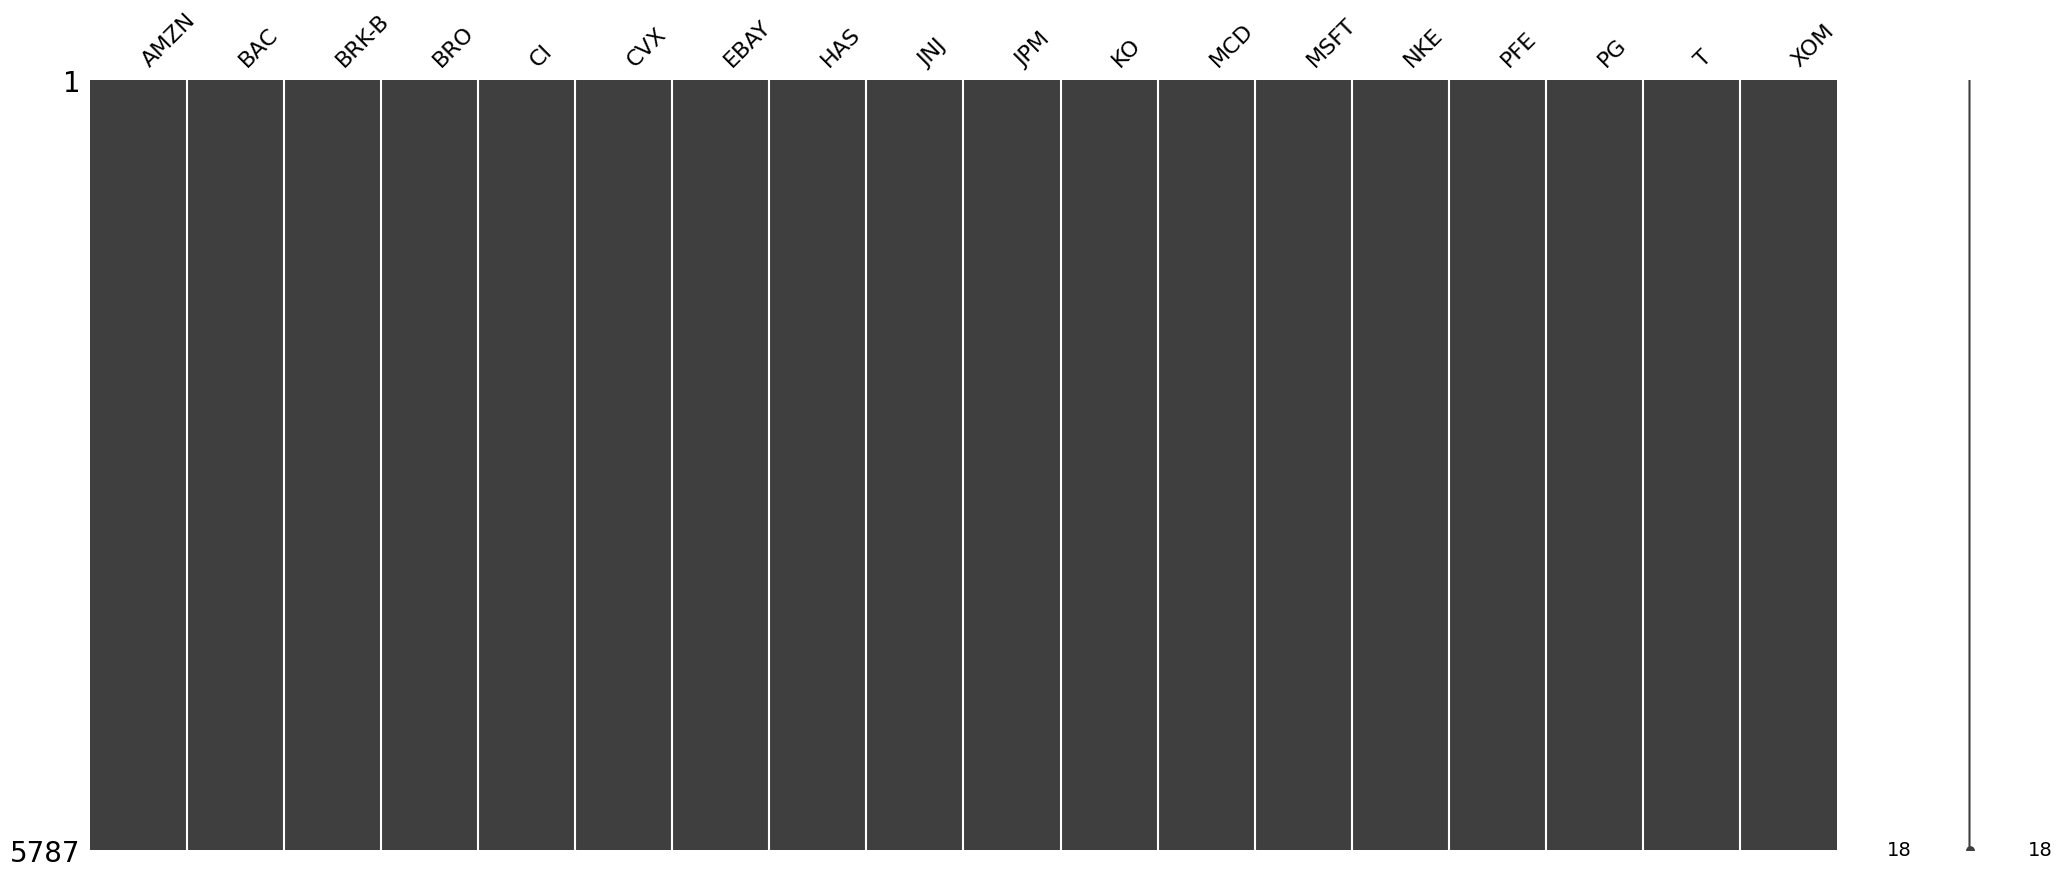

In [7]:
# Calculate daily adjusted closing prices
adj_close = data['Adj Close']

# Visualize missing values as a matrix
msno.matrix(adj_close)

### 1.2 Preprocessing <a id="section_1_2"></a>

In [8]:
# Calculate daily returns
returns = adj_close.pct_change().dropna()

# Display the first few rows of returns
returns.head()

Ticker,AMZN,BAC,BRK-B,BRO,CI,CVX,EBAY,HAS,JNJ,JPM,KO,MCD,MSFT,NKE,PFE,PG,T,XOM
Date,,,,,,,,,,,,,,,,,,
2000-01-04 00:00:00+00:00,-0.083217,-0.059355,-0.034561,0.000000,-0.003984,0.000000,-0.093805,-0.064406,-0.036610,-0.021942,0.001109,-0.020505,-0.033780,-0.054545,-0.037255,-0.019243,-0.058510,-0.019154
2000-01-05 00:00:00+00:00,-0.148741,0.010974,0.016432,-0.003300,-0.004001,0.017938,0.066894,-0.047102,0.010556,-0.006173,0.008859,0.016103,0.010544,0.057692,0.016293,-0.019024,0.015537,0.054515
2000-01-06 00:00:00+00:00,-0.060036,0.085481,0.041571,0.000000,0.048193,0.042584,-0.012357,-0.026616,0.031337,0.014197,0.001098,-0.014263,-0.033498,-0.005195,0.036072,0.046060,-0.019375,0.051697
2000-01-07 00:00:00+00:00,0.061010,-0.026250,0.008869,0.013244,0.043678,0.017606,-0.000927,0.035156,0.042539,0.018372,0.065790,0.025723,0.013068,0.000000,0.067699,0.079954,0.008571,-0.002934
2000-01-10 00:00:00+00:00,-0.005391,-0.034660,-0.003846,0.016340,-0.005874,-0.026989,0.055659,0.045283,-0.025259,-0.017182,-0.031893,0.004702,0.007291,0.016972,-0.001812,-0.004828,0.014165,-0.013981


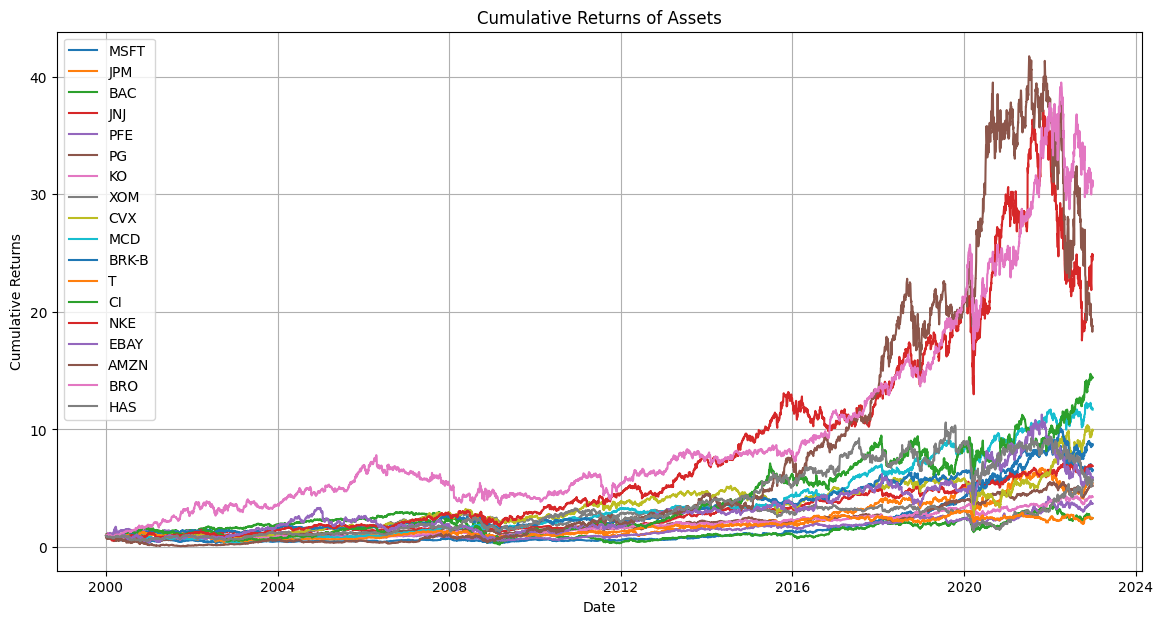

In [9]:
# Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(cumulative_returns[ticker], label=ticker)

plt.title('Cumulative Returns of Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

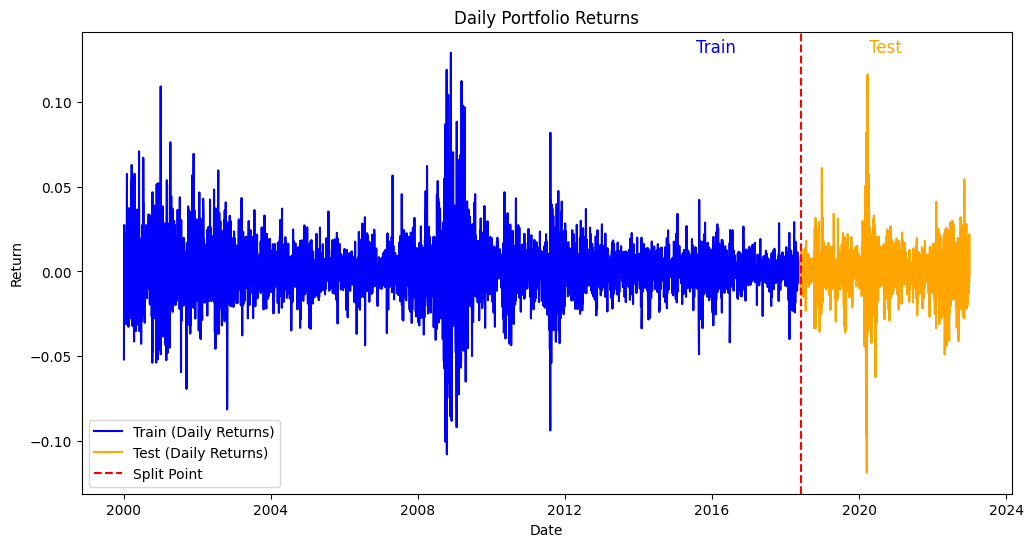

In [ ]:
portfolio_returns = returns.dot(weights)

# Define the split point
split = int(TRAIN_DATE_PERC * len(portfolio_returns))

# Plot the portfolio returns with different colors for train and test
plt.figure(figsize=(12, 6))

# Plot training data in blue
plt.plot(
    portfolio_returns.index[:split],
    portfolio_returns.values[:split],
    color="blue",
    label="Train (Daily Returns)",
)

# Plot testing data in orange
plt.plot(
    portfolio_returns.index[split:],
    portfolio_returns.values[split:],
    color="orange",
    label="Test (Daily Returns)",
)

# Add the vertical split line
plt.axvline(
    x=portfolio_returns.index[split], color="red", linestyle="--", label="Split Point"
)

# Add text annotations for Train and Test sections
plt.text(
    portfolio_returns.index[split - int(0.1 * len(portfolio_returns))],
    max(portfolio_returns.values),
    "Train",
    color="blue",
    fontsize=12,
    ha="center",
)
plt.text(
    portfolio_returns.index[split + int(0.1 * len(portfolio_returns))],
    max(portfolio_returns.values),
    "Test",
    color="orange",
    fontsize=12,
    ha="center",
)

# Additional plot settings
plt.title("Daily Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

## 2. Benchmark Models for VaR <a id="section_2"></a>

### 2.1 Historical Simulation <a id="section_2_1"></a>

In [ ]:
colors = {"Parametric": "orange", "Historical": "green", "Monte Carlo": "purple"}

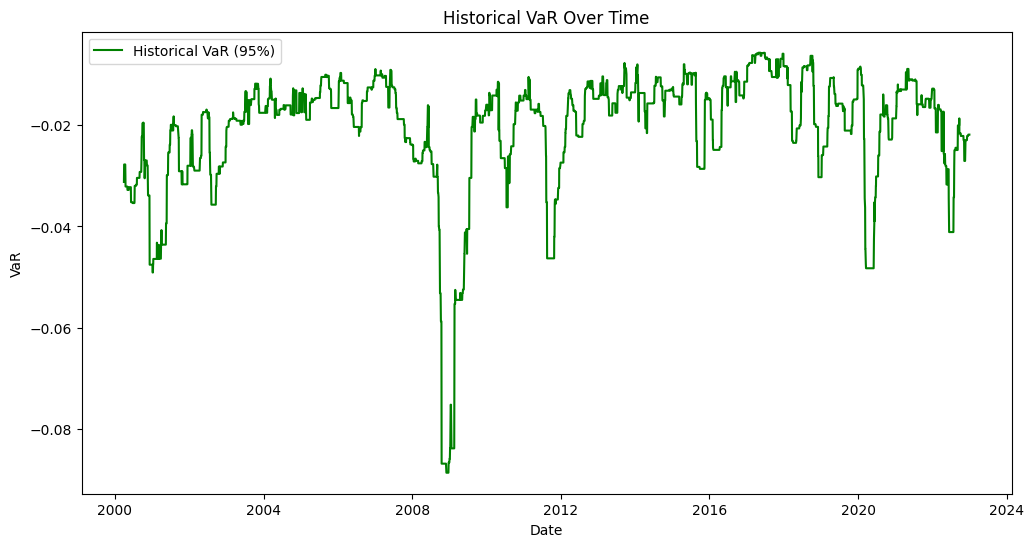

In [ ]:
# Calculate dynamic VaR using Historical Simulation with a rolling window
window_size = WINDOW_SIZE

historical_var = (
    portfolio_returns.rolling(window=window_size).quantile(1 - VAR / 100).dropna()
)

# Plot Historical VaR over time
plt.figure(figsize=(12, 6))
plt.plot(
    historical_var.index,
    historical_var.values,
    label=f"Historical VaR ({VAR}%)",
    color=colors["Historical"],
)
plt.title("Historical VaR Over Time")
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend()
plt.show()

### 2.2 Parametric VaR (Mean-Variance Method) <a id="section_2_2"></a>

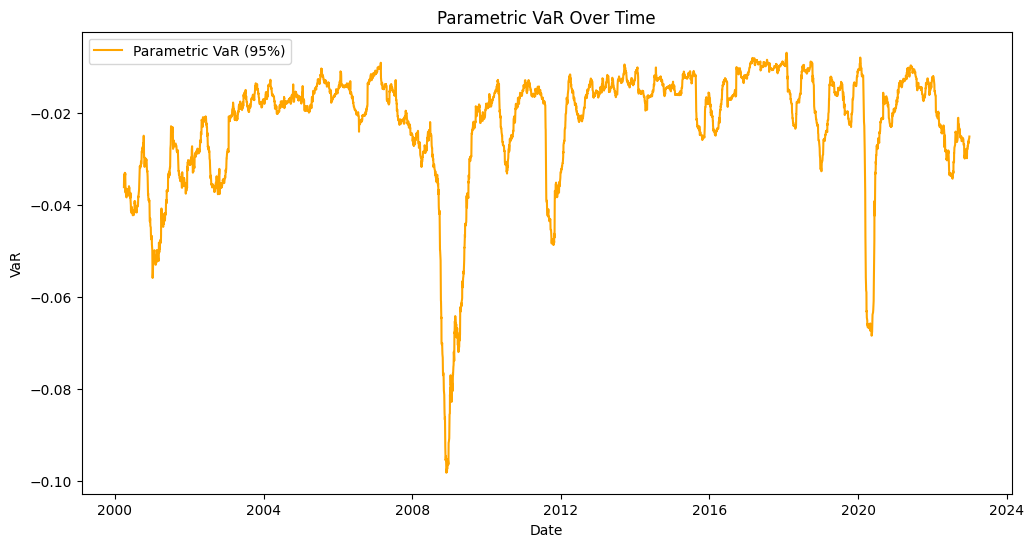

In [13]:
# Calculate dynamic Parametric VaR using rolling mean and std
mean_return = portfolio_returns.rolling(window=window_size).mean()
std_return = portfolio_returns.rolling(window=window_size).std()
z_score = norm.ppf(1 - VAR/100)  # Correct quantile for VAR% VaR

parametric_var = mean_return + z_score * std_return

# Remove NaN values
parametric_var = parametric_var.dropna()

# Plot Parametric VaR over time
plt.figure(figsize=(12, 6))
plt.plot(parametric_var.index, parametric_var.values, label=f'Parametric VaR ({VAR}%)', color=colors['Parametric'])
plt.title('Parametric VaR Over Time')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.show()

### 2.3 Monte Carlo Simulation for VaR Estimation <a id="section_2_3"></a>

In [14]:
# Function to perform Monte Carlo simulation
def monte_carlo_var_es(returns, num_simulations=10000, var_level=95):
    mu = returns.mean()
    sigma = returns.std()
    
    # Generate simulated returns
    simulated_returns = np.random.normal(mu, sigma, num_simulations)
    
    # Calculate VaR
    var = np.percentile(simulated_returns, 100 - var_level)
    
    # Calculate ES
    es = simulated_returns[simulated_returns <= var].mean()
    
    return var, es, simulated_returns

In [ ]:
# Define window size for rolling simulation
window_size = WINDOW_SIZE

# Initialize lists to store VaR and ES
mc_var_list = []
mc_es_list = []
mc_dates = []

# Loop over the data to perform rolling Monte Carlo simulations
for i in range(window_size, len(portfolio_returns)):
    # Use the previous 'window_size' returns to fit the distribution
    returns_window = portfolio_returns.iloc[i - window_size : i]

    # Perform Monte Carlo simulation
    var_mc, es_mc, simulated_returns_mc = monte_carlo_var_es(
        returns_window, num_simulations=10000, var_level=VAR
    )

    # Store the results
    mc_var_list.append(var_mc)
    mc_es_list.append(es_mc)
    mc_dates.append(portfolio_returns.index[i])

# Convert lists to pandas Series
# mc_var_series = pd.Series(mc_var_list, index=mc_dates)
mc_var = pd.Series(mc_var_list, index=mc_dates)
mc_es_series = pd.Series(mc_es_list, index=mc_dates)

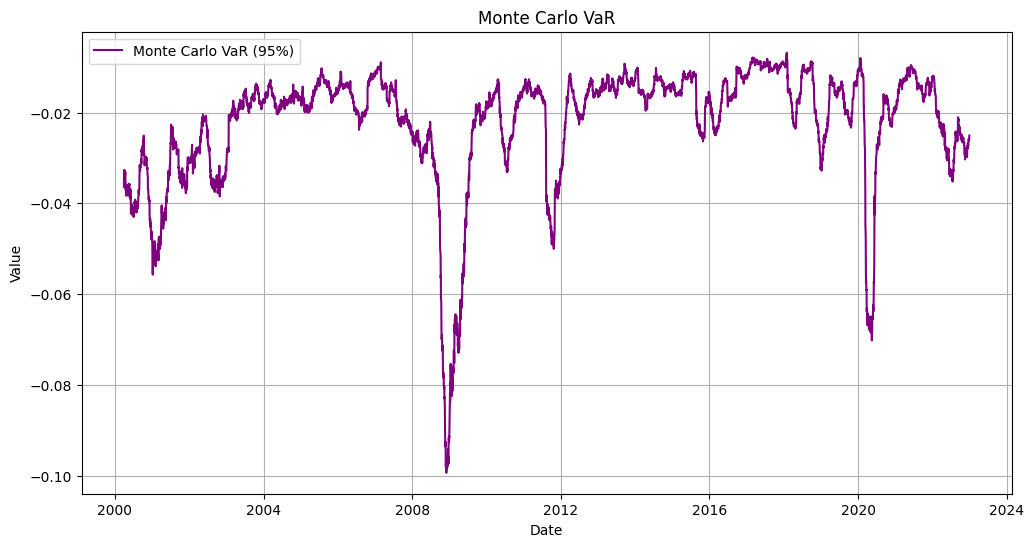

In [16]:
# Plot Monte Carlo VaR and ES over time
plt.figure(figsize=(12, 6))
plt.plot(mc_var.index, mc_var.values, label=f'Monte Carlo VaR ({VAR}%)', color=colors['Monte Carlo'])
plt.title('Monte Carlo VaR')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 3. Development of the Neural Network Model <a id="section_3"></a>

![LSTM-MDN Model Layers](images/model_structure2.png)

### 3.0 GPU Configuration <a id="section_3_0"></a>

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate a specific amount of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])#8192)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1732774719.657237 1205311 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


### 3.1 Data Preparation for LSTM <a id="section_3_1"></a>

In [18]:
# Feature scaling using StandardScaler
scaler = StandardScaler()

# 'portfolio_returns' is a pandas Series
returns_array = portfolio_returns.values.reshape(-1, 1)
scaled_returns = scaler.fit_transform(returns_array)

# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = WINDOW_SIZE
X, y = create_sequences(scaled_returns, time_steps)

# Split into training and test sets
X_train_seq, X_test_seq = X[:split], X[split:]
y_train_seq, y_test_seq = y[:split], y[split:]

print(f"Training set shape: {X_train_seq.shape}")
print(f"Test set shape: {X_test_seq.shape}")

Training set shape: (4628, 60, 1)
Test set shape: (1098, 60, 1)


In [19]:
# Expected exception rate for Kupiec's test
expected_exception_rate = round(1 - (VAR / 100), 4)  # For VAR% VaR

### 3.2 Loss Function and MDN Layer <a id="section_3_2"></a>

In [ ]:
class MDNLayer(Layer):
    def __init__(self, num_components, **kwargs):
        self.num_components = num_components
        super(MDNLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = self.num_components * 3
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.output_dim),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.bias = self.add_weight(
            name="bias", shape=(self.output_dim,), initializer="zeros", trainable=True
        )
        super(MDNLayer, self).build(input_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel) + self.bias
        out_mu = output[:, : self.num_components]
        out_sigma = K.exp(output[:, self.num_components : 2 * self.num_components])
        out_sigma = K.maximum(out_sigma, 1e-3)
        out_pi = K.softmax(output[:, 2 * self.num_components :])
        return K.concatenate([out_mu, out_sigma, out_pi], axis=1)

$$
\mathcal{L}_{\text{NLL}} = -\frac{1}{N} \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(y_i \mid \mu_k, \sigma_k) \right)
$$

In [ ]:
def mdn_loss(num_components):
    def loss(y_true, y_pred):
        y_true = K.reshape(y_true, (-1, 1))
        out_mu = y_pred[:, :num_components]
        out_sigma = y_pred[:, num_components : 2 * num_components]
        out_sigma = K.maximum(out_sigma, 1e-3)
        out_pi = y_pred[:, 2 * num_components :]

        # Compute the exponent
        exponent = -0.5 * K.square((y_true - out_mu) / out_sigma)
        # Compute the Gaussian distributions
        gaussians = K.exp(exponent) / (out_sigma * np.sqrt(2 * np.pi))
        # Compute the weighted sum
        weighted_gaussians = gaussians * out_pi
        # Sum over components
        total_pdf = K.sum(weighted_gaussians, axis=1)
        # Compute the negative log-likelihood
        loss = -K.log(total_pdf + 1e-10)
        return K.mean(loss)

    return loss

### 3.3 Attention Layer <a id="section_3_3"></a>

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Weight matrix for attention
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        # Bias term for attention
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute the attention scores
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        # Compute the attention weights
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context_vector = inputs * alpha
        context_vector = K.sum(context_vector, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

### 3.4 Monte Carlo Sampling Function <a id="section_3_4"></a>

In [ ]:
# Function to sample from the mixture model
def sample_from_output(y_pred, num_components, num_samples=5000):
    out_mu = y_pred[:, :num_components]
    out_sigma = y_pred[:, num_components : 2 * num_components]
    out_pi = y_pred[:, 2 * num_components :]

    samples = []
    for i in range(len(y_pred)):
        mu = out_mu[i]
        sigma = out_sigma[i]
        pi = out_pi[i]

        # Ensure probabilities sum to 1
        pi = pi / np.sum(pi)

        # Sample component indices
        component_indices = np.random.choice(
            np.arange(num_components), size=num_samples, p=pi
        )
        # Sample from the selected components
        sampled = np.random.normal(mu[component_indices], sigma[component_indices])
        samples.append(sampled)
    return np.array(samples)

### 3.5 Model Training with Multiple Optimizers <a id="section_3_5"></a>

In [ ]:
def build_model_with_optimizer(optimizer_name="adam", num_components=5):
    # Clear the session to reset the model
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed_value)

    # Define the input layer
    inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

    # LSTM layers with return_sequences=True
    lstm_out = LSTM(
        units=128,
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        kernel_initializer=GlorotNormal(seed=seed_value),
        recurrent_initializer=Orthogonal(seed=seed_value),
    )(inputs)
    lstm_out = Dropout(0.2)(lstm_out)

    lstm_out = LSTM(
        units=64,
        return_sequences=True,
        kernel_initializer=GlorotNormal(seed=seed_value),
        recurrent_initializer=Orthogonal(seed=seed_value),
    )(lstm_out)

    lstm_out = LSTM(
        units=32,
        return_sequences=True,
        kernel_initializer=GlorotNormal(seed=seed_value),
        recurrent_initializer=Orthogonal(seed=seed_value),
    )(lstm_out)

    # Attention layer
    attention_out = AttentionLayer()(lstm_out)

    # Use attention_out for the dense layer
    dense_out = Dense(
        16, activation="relu", kernel_initializer=GlorotNormal(seed=seed_value)
    )(attention_out)

    # MDN output layer
    outputs = MDNLayer(num_components)(dense_out)

    # Define the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    # Select optimizer
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    elif optimizer_name == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
    elif optimizer_name == "sgd_momentum":
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    elif optimizer_name == "sgd_momentum_nesterov":
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.01, momentum=0.9, nesterov=True
        )
    elif optimizer_name == "adadelta":
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
    elif optimizer_name == "adagrad":
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
    else:
        raise ValueError("Unsupported optimizer")

    # Compile the model
    model.compile(loss=mdn_loss(num_components), optimizer=optimizer)

    return model

In [24]:
# Define variables to store results
models = {}
histories = {}
exceptions_opt = {}
exception_rates = {}
p_values = {}
results_opt = {}
elapses = {}
y_preds = {}
mu_params = {}
sigma_params = {}
pi_params = {}

# Define number of mixture components
num_components = 5

# Define test data index
test_data_lstm_index = portfolio_returns.index[-(len(X_test_seq)-time_steps):]

In [ ]:
for opt in optimizer_list:
    # Adjusted callbacks to allow more epochs
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=30, min_lr=1e-8),
    ]

    start_time_flag = time.time()
    print(f"\nTraining model with optimizer: {opt.upper()}")

    # Clear session and reset seed before building the model
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed_value)

    model = build_model_with_optimizer(opt, num_components=num_components)

    # Train the model
    history = model.fit(
        X_train_seq,
        y_train_seq,
        epochs=EPOCHS,
        batch_size=64,
        validation_split=VALIDATION,
        callbacks=callbacks,
        verbose=0,
    )

    gc.collect()

    # Store the model and history
    models[opt] = model
    histories[opt] = history

    # Get predictions from the model
    y_pred = model.predict(X_test_seq)
    y_preds[opt] = y_pred  # Store predictions for further analysis

    # Extract mixture parameters
    out_mu = y_pred[:, :num_components]
    out_sigma = y_pred[:, num_components : 2 * num_components]
    out_pi = y_pred[:, 2 * num_components :]
    mu_params[opt] = out_mu
    sigma_params[opt] = out_sigma
    pi_params[opt] = out_pi

    # Initialize an empty list to store VaR estimates
    var_lstm_mdn = []

    # For each day, generate samples and compute VaR
    for i in range(len(y_pred)):
        samples = sample_from_output(
            y_pred[i : i + 1], num_components, num_samples=5000
        )
        # Inverse transform the samples
        samples = scaler.inverse_transform(samples.reshape(-1, 1)).flatten()
        # Calculate VaR for this day
        var_level = np.percentile(samples, 100 - VAR)  # VAR% VaR
        var_lstm_mdn.append(var_level)

    # Convert var_lstm_mdn to a pandas Series
    var_lstm_mdn_series = pd.Series(
        var_lstm_mdn, index=portfolio_returns.index[-len(var_lstm_mdn) :]
    )

    # Align actual portfolio_returns with VaR estimates
    actual_returns = portfolio_returns[-len(var_lstm_mdn_series) :]

    # Ensure data alignment
    var_lstm_mdn_series = var_lstm_mdn_series.loc[actual_returns.index]

    # Determine exceptions where actual return is less than VaR
    exceptions = actual_returns < var_lstm_mdn_series

    # Number of exceptions
    num_exceptions = exceptions.sum()
    total_observations = len(exceptions)
    exceptions_opt[opt] = num_exceptions

    # Exception rate
    exception_rate = num_exceptions / total_observations
    exception_rates[opt] = exception_rate

    # Kupiec's Test
    result_opt = binomtest(
        num_exceptions,
        total_observations,
        expected_exception_rate,
        alternative="two-sided",
    )
    p_value_opt = result_opt.pvalue
    p_values[opt] = p_value_opt

    # Store results
    results_opt_flag = pd.DataFrame(
        {
            "Actual_Returns": actual_returns.values,
            "Predicted_VaR": var_lstm_mdn_series.values,
            "Exceptions": exceptions.values.astype(int),
        },
        index=actual_returns.index,
    )

    results_opt[opt] = results_opt_flag

    elapses[opt] = time.time() - start_time_flag


Training model with optimizer: ADAM


2024-11-28 01:18:40.300705: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1732774721.673612 1205418 cuda_dnn.cc:529] Loaded cuDNN version 90300


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2024-11-28 01:19:09.327981: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training model with optimizer: NADAM
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2024-11-28 01:19:37.516363: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training model with optimizer: ADAGRAD
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2024-11-28 01:22:26.862818: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training model with optimizer: ADADELTA
 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step

2024-11-28 01:22:54.943951: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training model with optimizer: RMSPROP
 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step

2024-11-28 01:23:19.853040: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training model with optimizer: SGD
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2024-11-28 01:24:07.634168: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training model with optimizer: SGD_MOMENTUM
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2024-11-28 01:24:42.844158: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training model with optimizer: SGD_MOMENTUM_NESTEROV
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2024-11-28 01:25:15.398648: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [26]:
for opt in optimizer_list:
    print(f"Optimizer: {opt.upper()}")
    print(f"Number of exceptions: {exceptions_opt[opt]}")
    print(f"Exception rate: {exception_rates[opt]}")
    print(f"Training time {opt.upper()}: {elapses[opt]:.2f} seconds\n")

Optimizer: ADAM
Number of exceptions: 80
Exception rate: 0.07285974499089254
Training time ADAM: 30.19 seconds

Optimizer: NADAM
Number of exceptions: 65
Exception rate: 0.05919854280510018
Training time NADAM: 28.21 seconds

Optimizer: ADAGRAD
Number of exceptions: 67
Exception rate: 0.0610200364298725
Training time ADAGRAD: 169.34 seconds

Optimizer: ADADELTA
Number of exceptions: 55
Exception rate: 0.05009107468123861
Training time ADADELTA: 28.08 seconds

Optimizer: RMSPROP
Number of exceptions: 56
Exception rate: 0.051001821493624776
Training time RMSPROP: 24.87 seconds

Optimizer: SGD
Number of exceptions: 68
Exception rate: 0.061930783242258654
Training time SGD: 47.78 seconds

Optimizer: SGD_MOMENTUM
Number of exceptions: 67
Exception rate: 0.0610200364298725
Training time SGD_MOMENTUM: 35.21 seconds

Optimizer: SGD_MOMENTUM_NESTEROV
Number of exceptions: 69
Exception rate: 0.06284153005464481
Training time SGD_MOMENTUM_NESTEROV: 32.54 seconds



## 4. Backtesting and Validation <a id="section_4"></a>

### 4.1 Kupiec Test and Others <a id="section_4_1"></a>

In [27]:
for opt in optimizer_list:
    print(f"Optimizer: {opt.upper()}")
    print(f"Kupiec POF Test p-value: {p_values[opt]}\n")

Optimizer: ADAM
Kupiec POF Test p-value: 0.0010816915272365089

Optimizer: NADAM
Kupiec POF Test p-value: 0.16562082062256483

Optimizer: ADAGRAD
Kupiec POF Test p-value: 0.0963360019050384

Optimizer: ADADELTA
Kupiec POF Test p-value: 0.9448428059315421

Optimizer: RMSPROP
Kupiec POF Test p-value: 0.8355840578724907

Optimizer: SGD
Kupiec POF Test p-value: 0.07174950984980995

Optimizer: SGD_MOMENTUM
Kupiec POF Test p-value: 0.0963360019050384

Optimizer: SGD_MOMENTUM_NESTEROV
Kupiec POF Test p-value: 0.06099230476254784



### 4.2 Christoffersen Test <a id="section_4_2"></a>

In [ ]:
def christoffersen_test(violations):
    violations = np.array(violations)
    n = len(violations)

    # Transitions
    n00 = n01 = n10 = n11 = 0

    for i in range(1, n):
        if violations[i - 1] == 0 and violations[i] == 0:
            n00 += 1
        elif violations[i - 1] == 0 and violations[i] == 1:
            n01 += 1
        elif violations[i - 1] == 1 and violations[i] == 0:
            n10 += 1
        elif violations[i - 1] == 1 and violations[i] == 1:
            n11 += 1

    # Probabilities
    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Log-likelihood under null hypothesis (independence)
    LL_null = (n00 + n01) * np.log(1 - pi + 1e-10) + (n10 + n11) * np.log(pi + 1e-10)

    # Log-likelihood under alternative hypothesis (dependence)
    LL_alt = (
        n00 * np.log(1 - pi0 + 1e-10)
        + n01 * np.log(pi0 + 1e-10)
        + n10 * np.log(1 - pi1 + 1e-10)
        + n11 * np.log(pi1 + 1e-10)
    )

    # Likelihood Ratio test statistic
    LR_stat = -2 * (LL_null - LL_alt)

    # Degrees of freedom
    df = 1

    # P-value
    p_value = 1 - chi2.cdf(LR_stat, df)

    return LR_stat, p_value

In [ ]:
# Calculate Christoffersen Test for each optimizer
for opt in optimizer_list:
    exceptions = results_opt[opt]["Exceptions"]
    violations = exceptions.astype(int)
    LR_ind, p_value_ind = christoffersen_test(violations)
    print(f"Optimizer: {opt.upper()}")
    print(
        f"Christoffersen Independence Test LR Statistic: {LR_ind:.4f}, P-value: {p_value_ind:.4f}"
    )

    # Kupiec Test results are already stored
    # Calculate LR_uc manually
    N = len(violations)
    x = violations.sum()
    pi_hat = x / N
    pi0 = expected_exception_rate

    # Log-likelihood under null hypothesis
    LL_null = N * np.log(1 - pi0 + 1e-10) + x * np.log(pi0 / (1 - pi0) + 1e-10)

    # Log-likelihood under alternative hypothesis
    LL_alt = N * np.log(1 - pi_hat + 1e-10) + x * np.log(pi_hat / (1 - pi_hat) + 1e-10)

    LR_uc = -2 * (LL_null - LL_alt)

    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    print(
        f"Conditional Coverage Test LR Statistic: {LR_cc:.4f}, P-value: {p_value_cc:.4f}\n"
    )

Optimizer: ADAM
Christoffersen Independence Test LR Statistic: 2.9409, P-value: 0.0864
Conditional Coverage Test LR Statistic: 13.5919, P-value: 0.0011

Optimizer: NADAM
Christoffersen Independence Test LR Statistic: 0.3576, P-value: 0.5499
Conditional Coverage Test LR Statistic: 2.2093, P-value: 0.3313

Optimizer: ADAGRAD
Christoffersen Independence Test LR Statistic: 1.9820, P-value: 0.1592
Conditional Coverage Test LR Statistic: 4.6129, P-value: 0.0996

Optimizer: ADADELTA
Christoffersen Independence Test LR Statistic: 1.6665, P-value: 0.1967
Conditional Coverage Test LR Statistic: 1.6667, P-value: 0.4346

Optimizer: RMSPROP
Christoffersen Independence Test LR Statistic: 0.4555, P-value: 0.4997
Conditional Coverage Test LR Statistic: 0.4786, P-value: 0.7872

Optimizer: SGD
Christoffersen Independence Test LR Statistic: 0.7713, P-value: 0.3798
Conditional Coverage Test LR Statistic: 3.8398, P-value: 0.1466

Optimizer: SGD_MOMENTUM
Christoffersen Independence Test LR Statistic: 0.2152

## 5. Analysis of Results <a id="section_5"></a>

### 5.1 Visualization of Training Time <a id="section_5_1"></a>

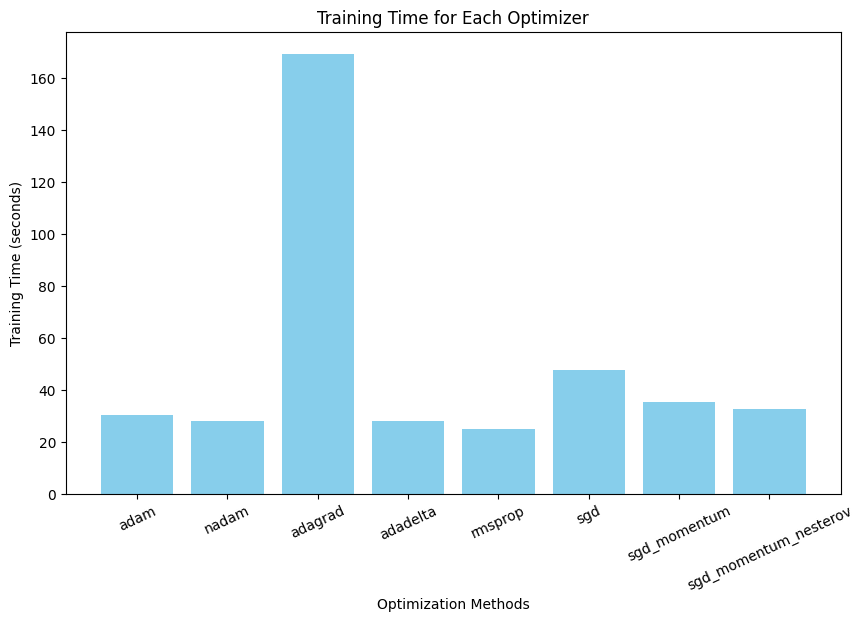

In [30]:
# Plot training times
plt.figure(figsize=(10, 6))
plt.bar(list(elapses.keys()), list(elapses.values()), color='skyblue')
plt.xlabel('Optimization Methods')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Optimizer')
plt.xticks(rotation=25)
plt.show()

### 5.2 Loss Plots per Optimizer <a id="section_5_2"></a>

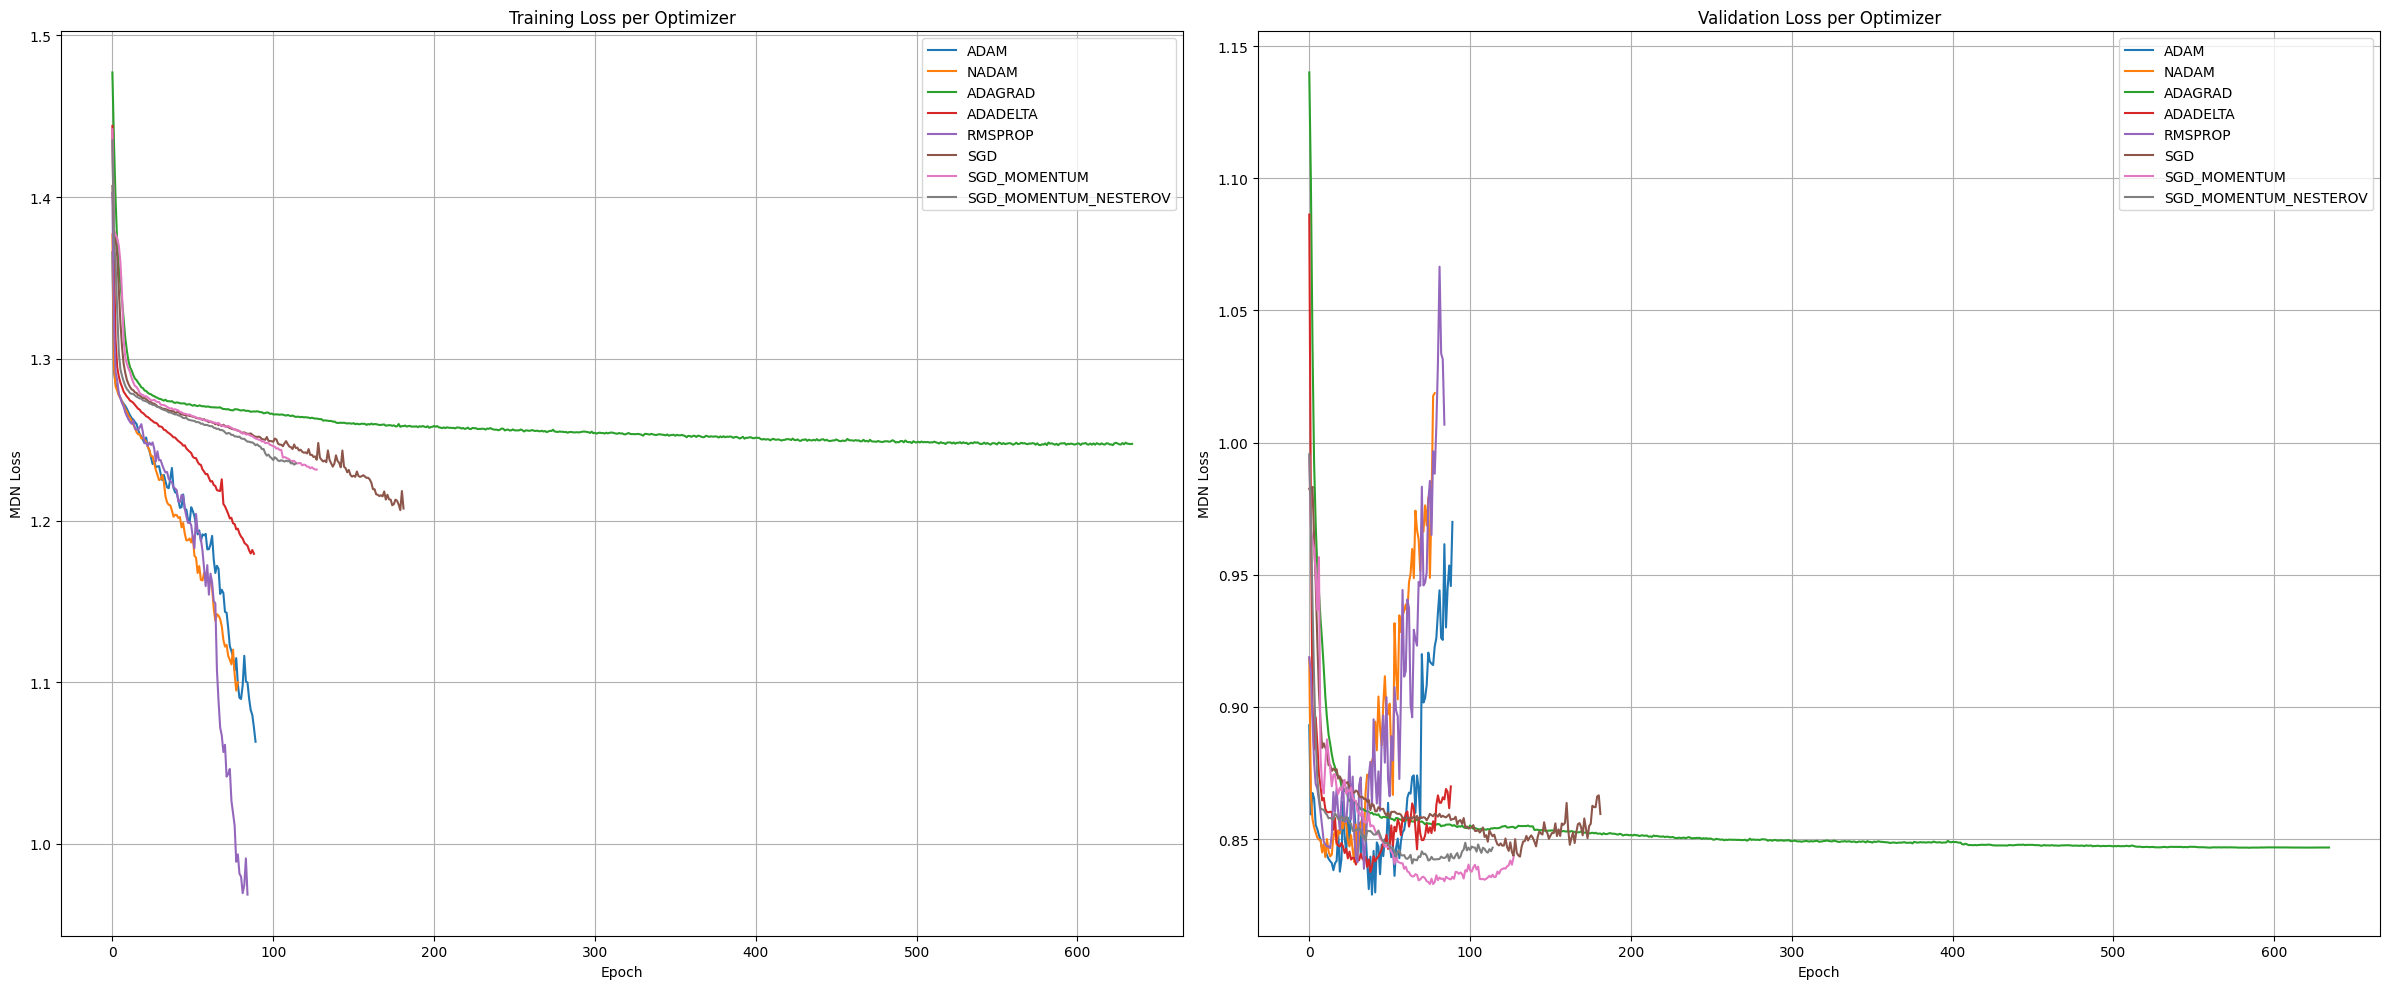

In [31]:
# Create two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), sharex=True)

# First subplot for Training Loss
for opt in optimizer_list:
    axes[0].plot(histories[opt].history['loss'], label=f'{opt.upper()}')
axes[0].set_title('Training Loss per Optimizer')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MDN Loss')
axes[0].legend()
axes[0].grid(True)

# Second subplot for Validation Loss
for opt in optimizer_list:
    axes[1].plot(histories[opt].history['val_loss'], label=f'{opt.upper()}')
axes[1].set_title('Validation Loss per Optimizer')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MDN Loss')
axes[1].legend()
axes[1].grid(True)

# Optimize the layout to prevent overlap
plt.tight_layout()
plt.show()

### 5.3 Attention Heatmap for All Test Examples <a id="section_5_3"></a>

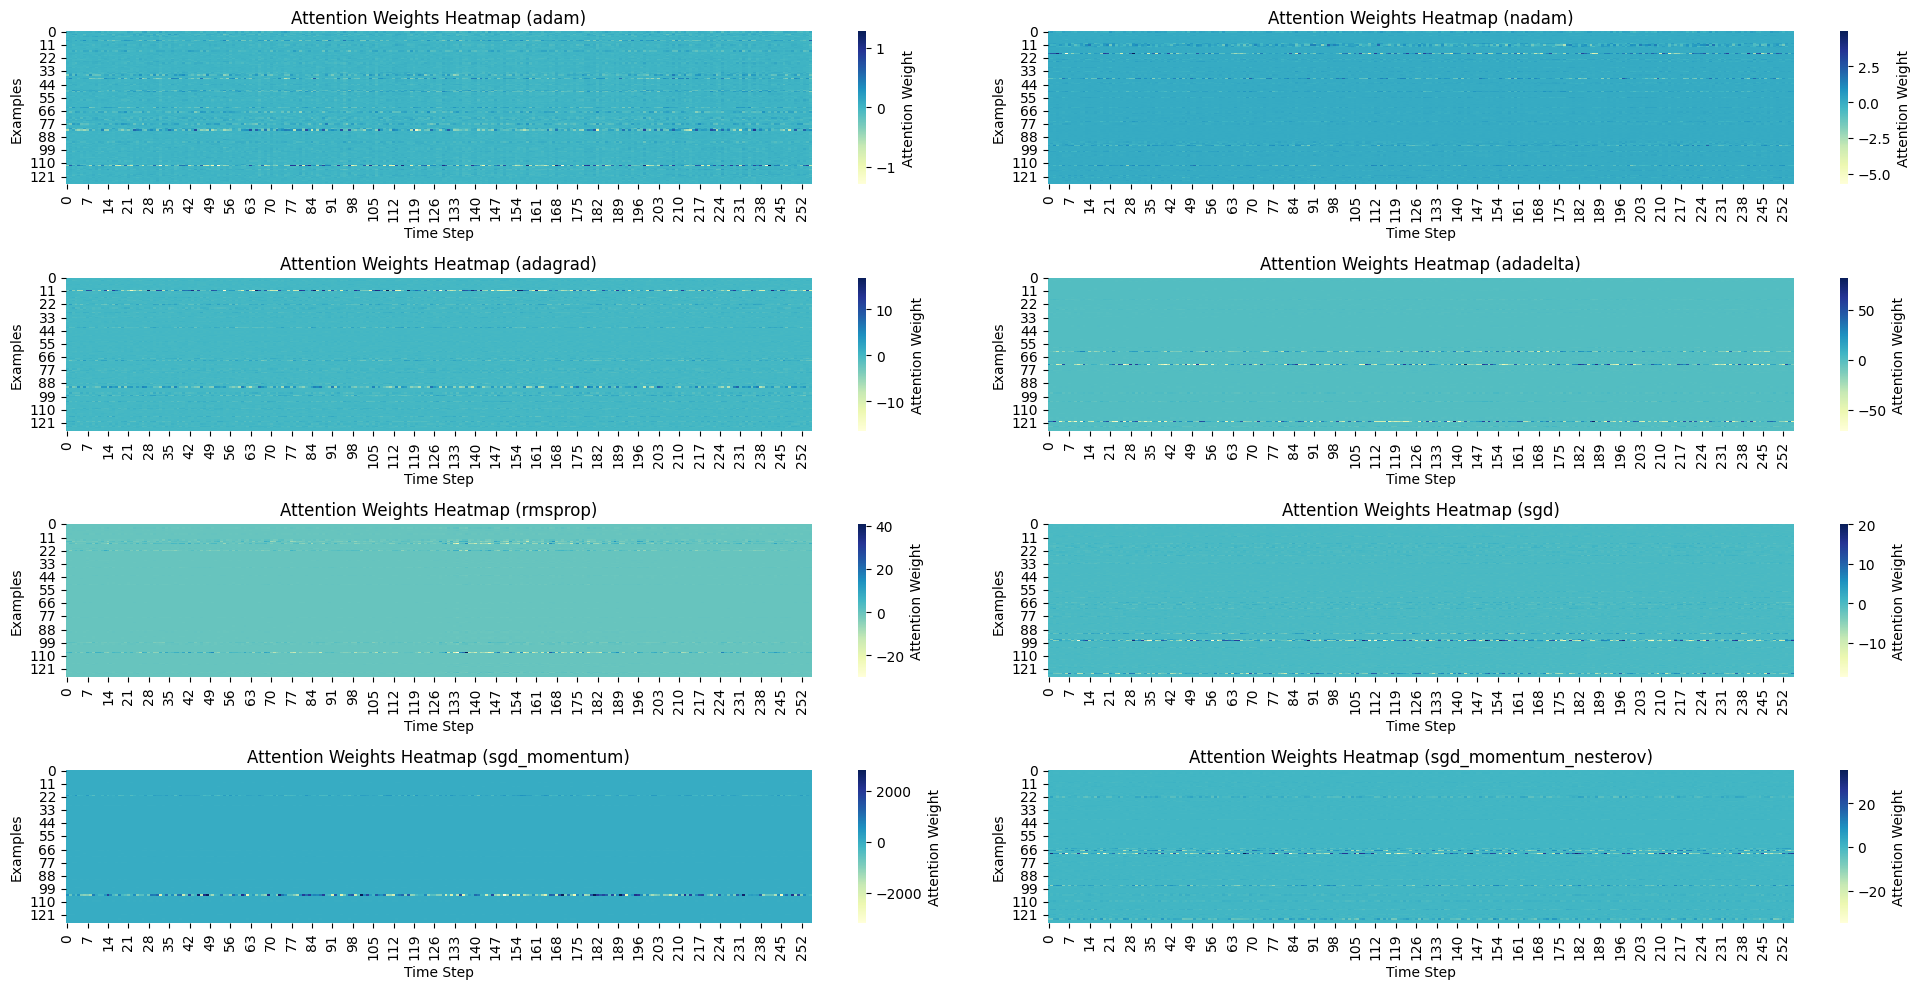

In [ ]:
# Create another grid of subplots for the attention heatmap
fig, axes = plt.subplots(nrows=int(len(optimizer_list) // 2), ncols=2, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over all models for the attention heatmap
for idx, (model_name, model) in enumerate(models.items()):
    # Extract attention weights
    attention_weights_all = model.layers[-5].get_weights()[0]  # Get attention weights

    # Normalize the attention weights
    attention_weights_normalized_all = attention_weights_all / np.sum(
        attention_weights_all, axis=1, keepdims=True
    )

    # Create the heatmap for attention weights across all sequences in the test set
    ax = axes[idx]
    sns.heatmap(
        attention_weights_normalized_all,
        cmap="YlGnBu",
        cbar_kws={"label": "Attention Weight"},
        ax=ax,
    )
    ax.set_title(f"Attention Weights Heatmap ({model_name})")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Examples")

plt.tight_layout()
plt.show()

#### 5.4 Performance Metrics Comparison (MAE and RMSE) <a id="section_5_4"></a>

In [ ]:
mae_opts = {}
rmse_opts = {}

for opt in optimizer_list:
    mae_opts[opt] = mean_absolute_error(
        results_opt[opt]["Actual_Returns"], results_opt[opt]["Predicted_VaR"]
    )
    rmse_opts[opt] = np.sqrt(
        mean_squared_error(
            results_opt[opt]["Actual_Returns"], results_opt[opt]["Predicted_VaR"]
        )
    )
    print(f"Performance Metrics for {opt.upper()} Optimizer:")
    print(f"Mean Absolute Error (MAE): {mae_opts[opt]:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_opts[opt]:.6f}\n")

Performance Metrics for ADAM Optimizer:
Mean Absolute Error (MAE): 0.021844
Root Mean Squared Error (RMSE): 0.026590

Performance Metrics for NADAM Optimizer:
Mean Absolute Error (MAE): 0.022844
Root Mean Squared Error (RMSE): 0.027749

Performance Metrics for ADAGRAD Optimizer:
Mean Absolute Error (MAE): 0.022995
Root Mean Squared Error (RMSE): 0.028236

Performance Metrics for ADADELTA Optimizer:
Mean Absolute Error (MAE): 0.024484
Root Mean Squared Error (RMSE): 0.029723

Performance Metrics for RMSPROP Optimizer:
Mean Absolute Error (MAE): 0.024219
Root Mean Squared Error (RMSE): 0.029265

Performance Metrics for SGD Optimizer:
Mean Absolute Error (MAE): 0.023015
Root Mean Squared Error (RMSE): 0.028258

Performance Metrics for SGD_MOMENTUM Optimizer:
Mean Absolute Error (MAE): 0.023306
Root Mean Squared Error (RMSE): 0.029166

Performance Metrics for SGD_MOMENTUM_NESTEROV Optimizer:
Mean Absolute Error (MAE): 0.022722
Root Mean Squared Error (RMSE): 0.028082



### 5.5 Comparison of VaR Levels <a id="section_5_5"></a>

#### 5.5.1 Plotting Actual Returns and VaR Estimates for Each Optimizer <a id="section_5_5_1"></a>

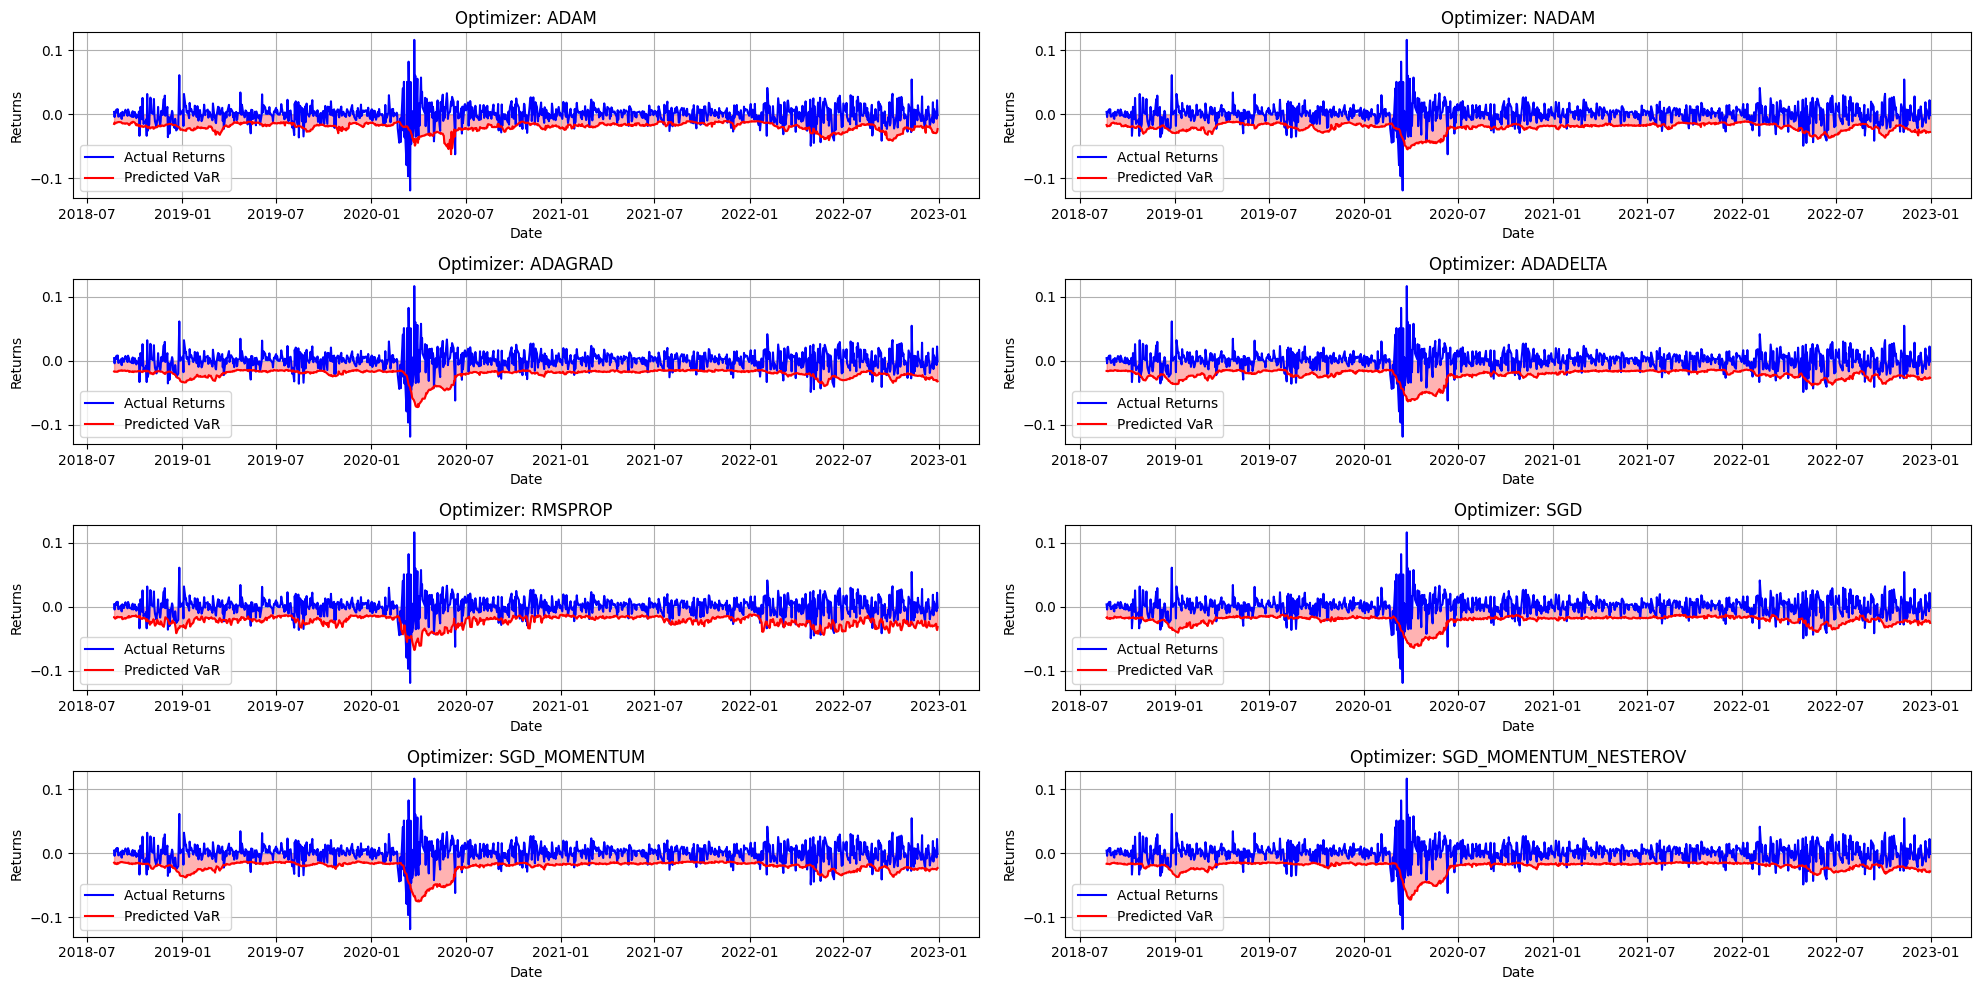

In [ ]:
# Plot actual portfolio_returns and VaR estimates for each optimizer
num_optimizers = len(optimizer_list)

# Create subplots: For 4 optimizers, a 2x2 grid works well
fig, axes = plt.subplots(nrows=int(len(optimizer_list) // 2), ncols=2, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over optimizers and corresponding axes
for idx, (opt, ax) in enumerate(zip(optimizer_list, axes)):
    ax.plot(
        results_opt[opt].index,
        results_opt[opt]["Actual_Returns"],
        label="Actual Returns",
        color="blue",
    )
    ax.plot(
        results_opt[opt].index,
        results_opt[opt]["Predicted_VaR"],
        label="Predicted VaR",
        color="red",
    )
    ax.fill_between(
        results_opt[opt].index,
        results_opt[opt]["Predicted_VaR"],
        color="red",
        alpha=0.3,
    )

    ax.set_title(f"Optimizer: {opt.upper()}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Returns")
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

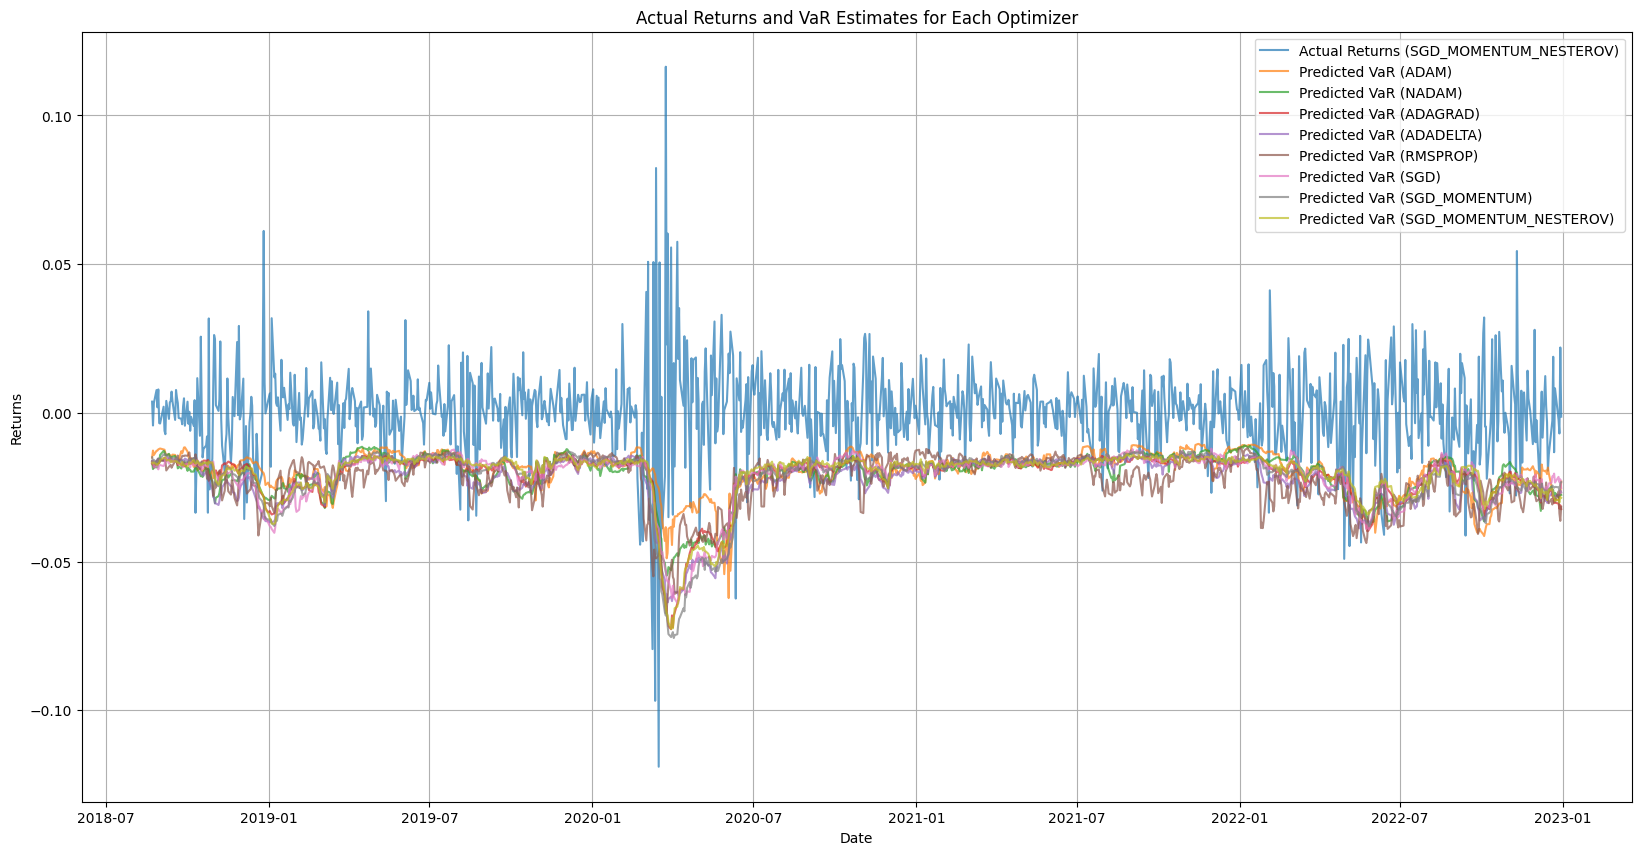

In [ ]:
# Plot actual portfolio_returns and VaR estimates for each optimizer in the same plot
plt.figure(figsize=(20, 10))

# Loop over optimizers to plot actual returns and predicted VaR for each optimizer
plt.plot(
    results_opt[opt].index,
    results_opt[opt]["Actual_Returns"],
    label=f"Actual Returns ({opt.upper()})",
    alpha=0.7,
)
for opt in optimizer_list:
    plt.plot(
        results_opt[opt].index,
        results_opt[opt]["Predicted_VaR"],
        label=f"Predicted VaR ({opt.upper()})",
        alpha=0.7,
    )

plt.title("Actual Returns and VaR Estimates for Each Optimizer")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Function to calculate the "Mean Overestimation" for non-exceedance cases
def mean_overestimation(actual_returns, var_series):
    # Filter cases where the return does not exceed VaR (non-exceedance cases)
    non_exceedances = actual_returns >= var_series
    
    # Calculate the distance for non-exceedance cases
    overestimations = actual_returns[non_exceedances] - var_series[non_exceedances]
    
    # Mean of the overestimations
    mean_overestimation_value = overestimations.mean()
    return mean_overestimation_value

In [37]:
# Expected Shortfall (ES) and Mean Excess Loss (MEL)
def expected_shortfall_MEL(portfolio_returns, var_series):
    # Ensure alignment
    portfolio_returns = portfolio_returns[var_series.index]
    exceedances = portfolio_returns[portfolio_returns < var_series]
    if len(exceedances) == 0:
        return np.nan
    es = exceedances.mean()
    mel = es - var_series.mean()
    return es, mel

In [38]:
es_opt_values = {}
mel_opt_values = {}

for k, v in results_opt.items():
    es, mel = expected_shortfall_MEL(actual_returns, v['Predicted_VaR'])
    es_opt_values[k] = float(es)
    mel_opt_values[k] = float(mel)

#### 5.5.2 Summarize Performance Metrics per Optimizer <a id="section_5_5_2"></a>

In [ ]:
# Create a DataFrame summarizing all the performance metrics
metrics_opt_df = pd.DataFrame(
    {
        "Model": [x.upper() for x in exceptions_opt],
        "Exceptions": [int(x) for x in exceptions_opt.values()],
        "Exception Rate": [float(x) for x in exception_rates.values()],
        "Kupiec p-value": [float(x) for x in p_values.values()],
        "Christoffersen p-value": [
            float(christoffersen_test(x["Exceptions"])[1]) for x in results_opt.values()
        ],
        "MAE": [float(x) for x in mae_opts.values()],
        "RMSE": [float(x) for x in rmse_opts.values()],
        "Overestimation": [
            float(mean_overestimation(actual_returns, x["Predicted_VaR"]))
            for x in results_opt.values()
        ],
        "ES": [x for x in es_opt_values.values()],
        "MEL": [x for x in mel_opt_values.values()],
    }
)

# Display the metrics DataFrame
metrics_opt_df

,Model,Exceptions,Exception Rate,Kupiec p-value,Christoffersen p-value,MAE,RMSE,Overestimation,ES,MEL
0,ADAM,80,0.072860,0.001082,0.086362,0.021844,0.026590,0.022630,-0.029772,-0.010080
1,NADAM,65,0.059199,0.165621,0.549851,0.022844,0.027749,0.023505,-0.032114,-0.011158
2,ADAGRAD,67,0.061020,0.096336,0.159181,0.022995,0.028236,0.023709,-0.031474,-0.010373
3,ADADELTA,55,0.050091,0.944843,0.196727,0.024484,0.029723,0.025136,-0.033668,-0.010825
4,RMSPROP,56,0.051002,0.835584,0.499730,0.024219,0.029265,0.024942,-0.033591,-0.010898
5,SGD,68,0.061931,0.071750,0.379803,0.023015,0.028258,0.023752,-0.031282,-0.010162
6,SGD_MOMENTUM,67,0.061020,0.096336,0.642724,0.023306,0.029166,0.024081,-0.030834,-0.009344
7,SGD_MOMENTUM_NESTEROV,69,0.062842,0.060992,0.088507,0.022722,0.028082,0.023451,-0.031018,-0.010214


### 5.6 Selection of the Best Optimizer and Comparison with Benchmark Models <a id="section_5_6"></a>

In [40]:
# Normalize function to scale each column between 0 and 1
def normalize_column(df, col_name, best_big=False):
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    if best_big:
        return (df[col_name] - min_val) / (max_val - min_val)
    else:
        return (max_val - df[col_name]) / (max_val - min_val)

In [ ]:
def score_metrics_df(df):
    # Normalize the relevant columns
    df["Normalized Kupiec p-value"] = normalize_column(
        df, "Kupiec p-value", best_big=True
    )
    df["Normalized Christoffersen p-value"] = normalize_column(
        df, "Christoffersen p-value", best_big=True
    )
    df["Normalized ES"] = normalize_column(df, "ES", best_big=True)
    df["Normalized MEL"] = normalize_column(df, "MEL", best_big=True)
    df["Normalized Overestimation"] = normalize_column(df, "Overestimation")
    df["Normalized MAE"] = normalize_column(df, "MAE")
    df["Normalized RMSE"] = normalize_column(df, "RMSE")

    # Adjust the weight for Exception Rate and Christoffersen p-value
    weights = {
        "Normalized ES": 0.23,  # Reduced since it's less critical for the VaR estimation
        "Normalized MEL": 0.11,  # Same as above
        "Normalized Kupiec p-value": 0.31,  # Weight to Kupiec p-value
        "Normalized Christoffersen p-value": 0.22,  # Increased weight to prioritize Christoffersen
        #'Normalized MAE': 0.05,  # Reduced weight for MAE
        #'Normalized RMSE': 0.05,  # Reduced weight for RMSE
        "Normalized Overestimation": 0.13,  # Slightly reduced to reflect less importance
    }

    # Recalculate the score after adjusting normalization and weights
    df["Score"] = (
        df["Normalized ES"] * weights["Normalized ES"]
        + df["Normalized MEL"] * weights["Normalized MEL"]
        + df["Normalized Kupiec p-value"] * weights["Normalized Kupiec p-value"]
        + df["Normalized Christoffersen p-value"]
        * weights["Normalized Christoffersen p-value"]
        +
        # df['Normalized MAE'] * weights['Normalized MAE'] +
        # df['Normalized RMSE'] * weights['Normalized RMSE'] +
        df["Normalized Overestimation"] * weights["Normalized Overestimation"]
    )

    # Calculate the deviation from VaR target
    exception_rate_diff = np.abs(df["Exception Rate"] - (1 - (VAR / 100)))

    # Penalize the score based on the deviation from the target VaR rate
    penalty_factor = 5
    df["Score"] -= penalty_factor * exception_rate_diff * 10

In [ ]:
score_metrics_df(metrics_opt_df)

# Find the optimizer with the highest score
best_optimizer_row = metrics_opt_df.loc[metrics_opt_df["Score"].idxmax()]

# Print the best optimizer and its details
print("Best Optimizer:")
print(
    best_optimizer_row[
        [
            "Model",
            "Score",
            "Exceptions",
            "Exception Rate",
            "ES",
            "MEL",
            "Overestimation",
        ]
    ]
)

Best Optimizer:
Model              RMSPROP
Score             0.417866
Exceptions              56
Exception Rate    0.051002
ES               -0.033591
MEL              -0.010898
Overestimation    0.024942
Name: 4, dtype: object


In [43]:
# Based on previous analyses, select the best optimizer
best_opt = best_optimizer_row['Model'].lower()
best_opt

'rmsprop'

In [44]:
models[best_opt].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 32)             │            92 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mdn_layer (MDNLayer)            │ (None, 15)             │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,520 (1009.85 KB)

 Trainable params: 129,259 (504.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,261 (504.93 KB)

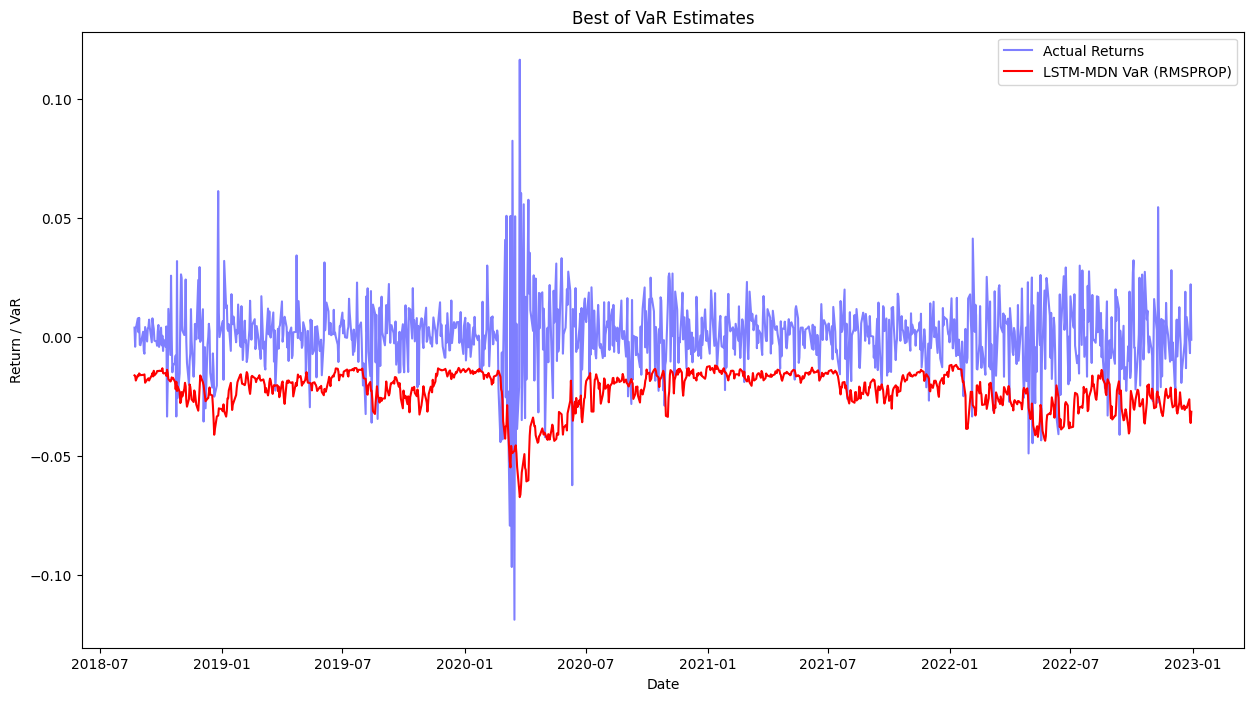

In [ ]:
common_index = portfolio_returns.index[-(len(y_test_seq)) :]
actual_returns_all = portfolio_returns.loc[common_index]

# For best_opt optimizer, align the VaR estimates
var_lstm_mdn_aligned = pd.Series(
    results_opt[best_opt]["Predicted_VaR"], index=common_index
)

plt.figure(figsize=(15, 8))
plt.plot(
    actual_returns_all.index,
    actual_returns_all.values,
    label="Actual Returns",
    color="blue",
    alpha=0.5,
)
plt.plot(
    var_lstm_mdn_aligned.index,
    var_lstm_mdn_aligned.values,
    label=f"LSTM-MDN VaR ({best_opt.upper()})",
    color="red",
)

plt.title("Best of VaR Estimates")
plt.xlabel("Date")
plt.ylabel("Return / VaR")
plt.legend()
plt.show()

### 5.7 Graphs and Visualizations <a id="section_5_7"></a>

#### 5.7.1 Distribution of Returns <a id="section_5_7_1"></a>

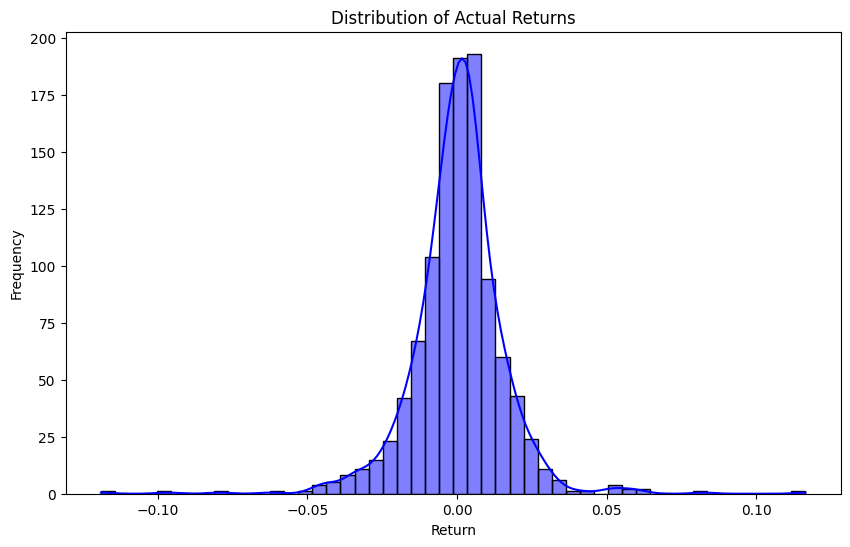

In [46]:
# Plot histogram of portfolio_returns
plt.figure(figsize=(10, 6))
sns.histplot(actual_returns_all, bins=50, kde=True, color='blue')
plt.title('Distribution of Actual Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

#### 5.7.2 Monte Carlo Simulation Distribution <a id="section_5_7_2"></a>

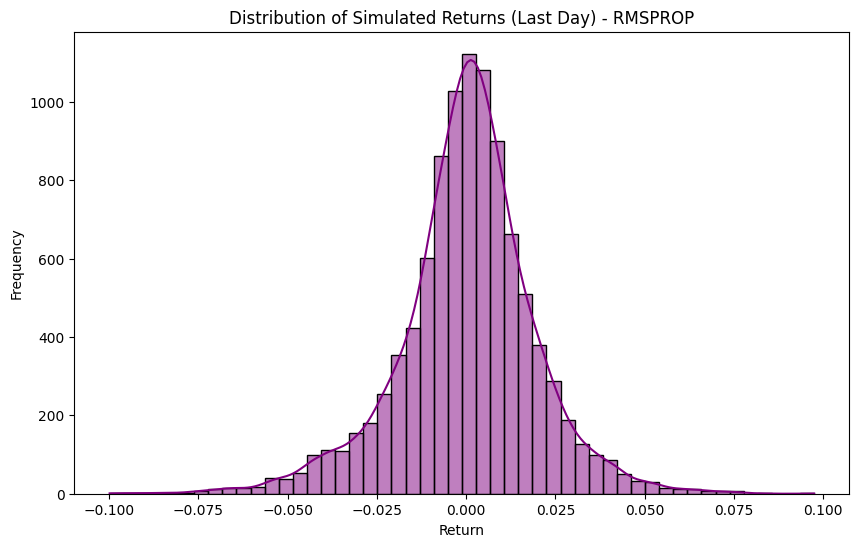

In [47]:
# Generate samples from the last prediction for best_opt optimizer
y_pred_last = y_preds[best_opt][-1:]
samples = sample_from_output(y_pred_last, num_components, num_samples=10000)
# Inverse transform the samples
samples = scaler.inverse_transform(samples.reshape(-1, 1)).flatten()

# Plot histogram of simulated portfolio_returns
plt.figure(figsize=(10, 6))
sns.histplot(samples, bins=50, kde=True, color='purple')
plt.title(f'Distribution of Simulated Returns (Last Day) - {best_opt.upper()}')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

#### 5.7.3 Model Error Heatmap <a id="section_5_7_3"></a>

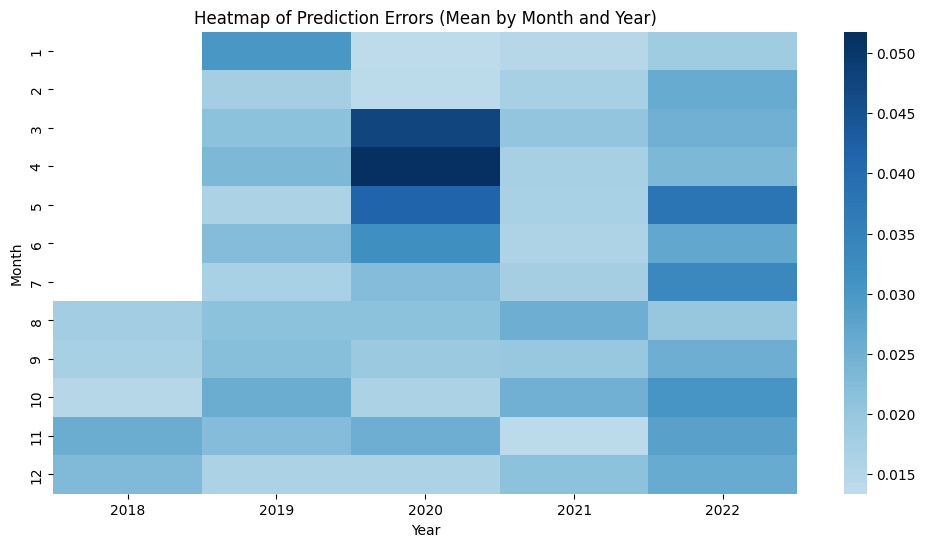

In [48]:
# Calculate errors
errors = results_opt[best_opt]['Actual_Returns'] - results_opt[best_opt]['Predicted_VaR']

# Reshape errors for heatmap (e.g., by year and month)
errors_df = errors.to_frame(name='Error')
errors_df['Year'] = errors_df.index.year
errors_df['Month'] = errors_df.index.month
pivot_table = errors_df.pivot_table(values='Error', index='Month', columns='Year', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='RdBu', center=0)
plt.title('Heatmap of Prediction Errors (Mean by Month and Year)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

## 6. Performance Metrics Comparison <a id="section_6"></a>

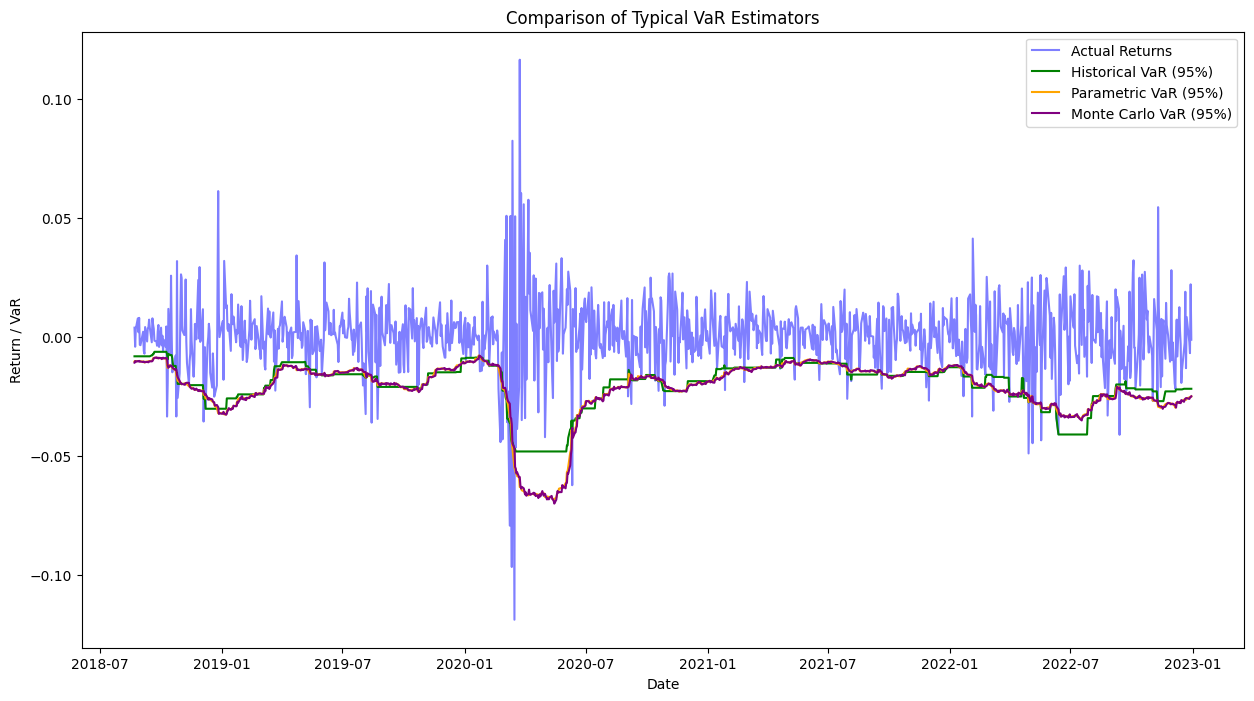

In [ ]:
# Align all VaR estimates
historical_var_aligned = historical_var.loc[common_index]
parametric_var_aligned = parametric_var.loc[common_index]
mc_var_aligned = mc_var.loc[common_index]

plt.figure(figsize=(15, 8))
plt.plot(
    actual_returns_all.index,
    actual_returns_all.values,
    label="Actual Returns",
    color="blue",
    alpha=0.5,
)
plt.plot(
    historical_var_aligned.index,
    historical_var_aligned.values,
    label=f"Historical VaR ({VAR}%)",
    color=colors["Historical"],
)
plt.plot(
    parametric_var_aligned.index,
    parametric_var_aligned.values,
    label=f"Parametric VaR ({VAR}%)",
    color=colors["Parametric"],
)
plt.plot(
    mc_var_aligned.index,
    mc_var_aligned.values,
    label=f"Monte Carlo VaR ({VAR}%)",
    color=colors["Monte Carlo"],
)

plt.title("Comparison of Typical VaR Estimators")
plt.xlabel("Date")
plt.ylabel("Return / VaR")
plt.legend()
plt.show()

### 6.1 Calculations <a id="section_6_1"></a>

#### 6.1.1 Exceptions <a id="section_6_1_1"></a>

In [ ]:
# Extract the VaR predictions for best_opt from the results_opt dictionary
best_opt_var = results_opt[best_opt]["Predicted_VaR"]

# Calculate exceptions
exceptions_historical = actual_returns < historical_var_aligned
exceptions_parametric = actual_returns < parametric_var_aligned
exceptions_mc = actual_returns < mc_var_aligned

# Number of exceptions
num_exceptions_historical = exceptions_historical.sum()
num_exceptions_parametric = exceptions_parametric.sum()
num_exceptions_mc = exceptions_mc.sum()

# Frequency of exceptions
exception_rate_historical = num_exceptions_historical / len(exceptions_historical)
exception_rate_parametric = num_exceptions_parametric / len(exceptions_parametric)
exception_rate_mc = num_exceptions_mc / len(exceptions_mc)

print(
    f"Historical - Number of exceptions: {num_exceptions_historical}, Frequency: {exception_rate_historical}"
)
print(
    f"Parametric - Number of exceptions: {num_exceptions_parametric}, Frequency: {exception_rate_parametric}"
)
print(
    f"Monte Carlo - Number of exceptions: {num_exceptions_mc}, Frequency: {exception_rate_mc}"
)

Historical - Number of exceptions: 59, Frequency: 0.05373406193078324
Parametric - Number of exceptions: 64, Frequency: 0.058287795992714025
Monte Carlo - Number of exceptions: 70, Frequency: 0.06375227686703097


#### 6.1.2 Kupiec POF Test <a id="section_6_1_2"></a>

In [51]:
# Function for Kupiec Test
def kupiec_test(num_exceptions, total):
    expected = round(1 - (VAR / 100), 4)  # For VAR% VaR
    result = binomtest(num_exceptions, total, expected, alternative='two-sided')
    return result.pvalue

# Calculate p-values
p_value_historical = kupiec_test(num_exceptions_historical, len(exceptions_historical))
p_value_parametric = kupiec_test(num_exceptions_parametric, len(exceptions_parametric))
p_value_mc = kupiec_test(num_exceptions_mc, len(exceptions_mc))

print(f"Historical - Kupiec POF Test p-value: {p_value_historical}")
print(f"Parametric - Kupiec POF Test p-value: {p_value_parametric}")
print(f"Monte Carlo - Kupiec POF Test p-value: {p_value_mc}")

Historical - Kupiec POF Test p-value: 0.5791678461127606
Parametric - Kupiec POF Test p-value: 0.21206250503255183
Monte Carlo - Kupiec POF Test p-value: 0.04415608153244038


#### 6.1.3 Christoffersen <a id="section_6_1_3"></a>

In [52]:
# Calculate p-values for Christoffersen
violations_historical = exceptions_historical.astype(int)
violations_parametric = exceptions_parametric.astype(int)
violations_mc = exceptions_mc.astype(int)

LR_ind_historical, p_value_ind_historical = christoffersen_test(violations_historical)
LR_ind_parametric, p_value_ind_parametric = christoffersen_test(violations_parametric)
LR_ind_mc, p_value_ind_mc = christoffersen_test(violations_mc)

In [53]:
# Calculate the Conditional Coverage Test
def conditional_coverage_test(num_exceptions, total, violations):
    # Kupiec Test
    p_kupiec = kupiec_test(num_exceptions, total)

    # Christoffersen Test
    LR_ind, p_ind = christoffersen_test(violations)

    # Likelihood Ratio for Conditional Coverage
    # Assume that Kupiec's test is separate; for simplicity, consider just reporting both
    return LR_ind, p_ind

In [ ]:
LR_cc_historical, p_value_cc_historical = conditional_coverage_test(
    num_exceptions_historical, len(exceptions_historical), violations_historical
)
LR_cc_parametric, p_value_cc_parametric = conditional_coverage_test(
    num_exceptions_parametric, len(exceptions_parametric), violations_parametric
)
LR_cc_mc, p_value_cc_mc = conditional_coverage_test(
    num_exceptions_mc, len(exceptions_mc), violations_mc
)

print(
    f"Historical - Christoffersen Independence Test LR Statistic: {LR_ind_historical:.4f}, P-value: {p_value_ind_historical:.4f}"
)
print(
    f"Historical - Conditional Coverage Test LR Statistic: {LR_cc_historical:.4f}, P-value: {p_value_cc_historical:.4f}\n"
)

print(
    f"Parametric - Christoffersen Independence Test LR Statistic: {LR_ind_parametric:.4f}, P-value: {p_value_ind_parametric:.4f}"
)
print(
    f"Parametric - Conditional Coverage Test LR Statistic: {LR_cc_parametric:.4f}, P-value: {p_value_cc_parametric:.4f}\n"
)

print(
    f"Monte Carlo - Christoffersen Independence Test LR Statistic: {LR_ind_mc:.4f}, P-value: {p_value_ind_mc:.4f}"
)
print(
    f"Monte Carlo - Conditional Coverage Test LR Statistic: {LR_cc_mc:.4f}, P-value: {p_value_cc_mc:.4f}\n"
)

Historical - Christoffersen Independence Test LR Statistic: 2.2900, P-value: 0.1302
Historical - Conditional Coverage Test LR Statistic: 2.2900, P-value: 0.1302

Parametric - Christoffersen Independence Test LR Statistic: 2.6379, P-value: 0.1043
Parametric - Conditional Coverage Test LR Statistic: 2.6379, P-value: 0.1043

Monte Carlo - Christoffersen Independence Test LR Statistic: 1.4281, P-value: 0.2321
Monte Carlo - Conditional Coverage Test LR Statistic: 1.4281, P-value: 0.2321



#### 6.1.4 MAE and RMSE <a id="section_6_1_4"></a>

In [55]:
# MAE and RMSE for Historical
mae_historical = mean_absolute_error(actual_returns, historical_var_aligned)
rmse_historical = np.sqrt(mean_squared_error(actual_returns, historical_var_aligned))

# MAE and RMSE for Parametric
mae_parametric = mean_absolute_error(actual_returns, parametric_var_aligned)
rmse_parametric = np.sqrt(mean_squared_error(actual_returns, parametric_var_aligned))

# MAE and RMSE for Monte Carlo
mae_mc = mean_absolute_error(actual_returns, mc_var_aligned)
rmse_mc = np.sqrt(mean_squared_error(actual_returns, mc_var_aligned))

print(f"Historical - MAE: {mae_historical:.6f}, RMSE: {rmse_historical:.6f}")
print(f"Parametric - MAE: {mae_parametric:.6f}, RMSE: {rmse_parametric:.6f}")
print(f"Monte Carlo - MAE: {mae_mc:.6f}, RMSE: {rmse_mc:.6f}")

Historical - MAE: 0.022029, RMSE: 0.027697
Parametric - MAE: 0.023294, RMSE: 0.029784
Monte Carlo - MAE: 0.023496, RMSE: 0.029960


#### 6.1.5 Overestimation <a id="section_6_1_5"></a>

In [56]:
# Apply the function for each model
mean_overestimation_best_opt = mean_overestimation(actual_returns, best_opt_var)
mean_overestimation_historical = mean_overestimation(actual_returns, historical_var_aligned)
mean_overestimation_parametric = mean_overestimation(actual_returns, parametric_var_aligned)
mean_overestimation_mc = mean_overestimation(actual_returns, mc_var_aligned)

# Display results
print(f"Mean Overestimation for {best_opt.upper()} Optimizer: {mean_overestimation_best_opt:.6f}")
print(f"Mean Overestimation for Historical VaR: {mean_overestimation_historical:.6f}")
print(f"Mean Overestimation for Parametric VaR: {mean_overestimation_parametric:.6f}")
print(f"Mean Overestimation for Monte Carlo VaR: {mean_overestimation_mc:.6f}")

Mean Overestimation for RMSPROP Optimizer: 0.024942
Mean Overestimation for Historical VaR: 0.022636
Mean Overestimation for Parametric VaR: 0.024093
Mean Overestimation for Monte Carlo VaR: 0.024346


#### 6.1.6 Expected Shortfall (ES) and Mean Excess Loss (MEL) <a id="section_6_1_6"></a>

In [57]:
# ES and MEL for all models
es_best_opt, mel_best_opt = expected_shortfall_MEL(actual_returns, best_opt_var)
es_historical, mel_historical = expected_shortfall_MEL(actual_returns, historical_var_aligned)
es_parametric, mel_parametric = expected_shortfall_MEL(actual_returns, parametric_var_aligned)
es_mc, mel_mc = expected_shortfall_MEL(actual_returns, mc_var_aligned)

print(f"{best_opt.upper()} - Expected Shortfall (ES): {es_best_opt:.6f}, MEL: {mel_best_opt:.6f}")
print(f"Historical - Expected Shortfall (ES): {es_historical:.6f}, MEL: {mel_historical:.6f}")
print(f"Parametric - Expected Shortfall (ES): {es_parametric:.6f}, MEL: {mel_parametric:.6f}")
print(f"Monte Carlo - Expected Shortfall (ES): {es_mc:.6f}, MEL: {mel_mc:.6f}")

RMSPROP - Expected Shortfall (ES): -0.033591, MEL: -0.010898
Historical - Expected Shortfall (ES): -0.030485, MEL: -0.010102
Parametric - Expected Shortfall (ES): -0.030484, MEL: -0.008828
Monte Carlo - Expected Shortfall (ES): -0.029609, MEL: -0.007944


### 6.2 Summarize Performance Metrics <a id="section_6_2"></a>

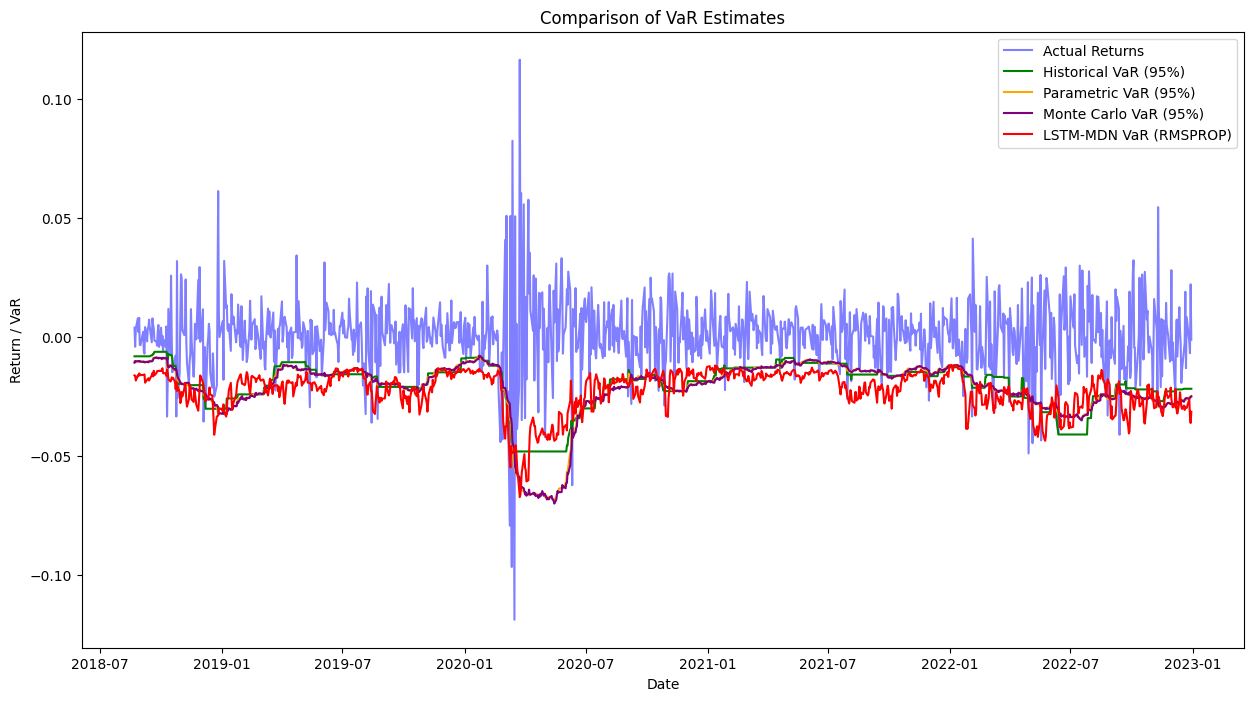

In [ ]:
# Plot VaR estimates
plt.figure(figsize=(15, 8))
plt.plot(
    actual_returns_all.index,
    actual_returns_all.values,
    label="Actual Returns",
    color="blue",
    alpha=0.5,
)
plt.plot(
    historical_var_aligned.index,
    historical_var_aligned.values,
    label=f"Historical VaR ({VAR}%)",
    color=colors["Historical"],
)
plt.plot(
    parametric_var_aligned.index,
    parametric_var_aligned.values,
    label=f"Parametric VaR ({VAR}%)",
    color=colors["Parametric"],
)
plt.plot(
    mc_var_aligned.index,
    mc_var_aligned.values,
    label=f"Monte Carlo VaR ({VAR}%)",
    color=colors["Monte Carlo"],
)
plt.plot(
    var_lstm_mdn_aligned.index,
    var_lstm_mdn_aligned.values,
    label=f"LSTM-MDN VaR ({best_opt.upper()})",
    color="red",
)

plt.title("Comparison of VaR Estimates")
plt.xlabel("Date")
plt.ylabel("Return / VaR")
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame summarizing all the performance metrics
metrics_df = pd.DataFrame(
    {
        "Model": [
            f"LSTM-MDN ({best_opt.upper()})",
            "Historical VaR",
            "Parametric VaR",
            "Monte Carlo VaR",
        ],
        "Exceptions": [
            exceptions_opt[best_opt],
            num_exceptions_historical,
            num_exceptions_parametric,
            num_exceptions_mc,
        ],
        "Exception Rate": [
            exception_rates[best_opt],
            exception_rate_historical,
            exception_rate_parametric,
            exception_rate_mc,
        ],
        "Kupiec p-value": [
            p_values[best_opt],
            p_value_historical,
            p_value_parametric,
            p_value_mc,
        ],
        "Christoffersen p-value": [
            christoffersen_test(results_opt[best_opt]["Exceptions"])[1],
            p_value_ind_historical,
            p_value_ind_parametric,
            p_value_ind_mc,
        ],
        "MAE": [
            mean_absolute_error(
                results_opt[best_opt]["Actual_Returns"],
                results_opt[best_opt]["Predicted_VaR"],
            ),
            mae_historical,
            mae_parametric,
            mae_mc,
        ],
        "RMSE": [
            np.sqrt(
                mean_squared_error(
                    results_opt[best_opt]["Actual_Returns"],
                    results_opt[best_opt]["Predicted_VaR"],
                )
            ),
            rmse_historical,
            rmse_parametric,
            rmse_mc,
        ],
        "Overestimation": [
            mean_overestimation_best_opt,
            mean_overestimation_historical,
            mean_overestimation_parametric,
            mean_overestimation_mc,
        ],
        "ES": [es_opt_values[best_opt], es_historical, es_parametric, es_mc],
        "MEL": [mel_opt_values[best_opt], mel_historical, mel_parametric, mel_mc],
    }
)

# Display the metrics DataFrame
metrics_df.set_index("Model", inplace=True)
score_metrics_df(metrics_df)
metrics_df[
    [
        "Score",
        "Exceptions",
        "Exception Rate",
        "Kupiec p-value",
        "Christoffersen p-value",
        "MAE",
        "RMSE",
        "Overestimation",
        "ES",
        "MEL",
    ]
]

,Score,Exceptions,Exception Rate,Kupiec p-value,Christoffersen p-value,MAE,RMSE,Overestimation,ES,MEL
Model,,,,,,,,,,
LSTM-MDN (RMSPROP),0.479909,56,0.051002,0.835584,0.499730,0.024219,0.029265,0.024942,-0.033591,-0.010898
Historical VaR,0.376301,59,0.053734,0.579168,0.130211,0.022029,0.027697,0.022636,-0.030485,-0.010102
Parametric VaR,-0.044209,64,0.058288,0.212063,0.104342,0.023294,0.029784,0.024093,-0.030484,-0.008828
Monte Carlo VaR,-0.242950,70,0.063752,0.044156,0.232073,0.023496,0.029960,0.024346,-0.029609,-0.007944


### 6.3 Visualization of Market Regimes <a id="section_6_3"></a>

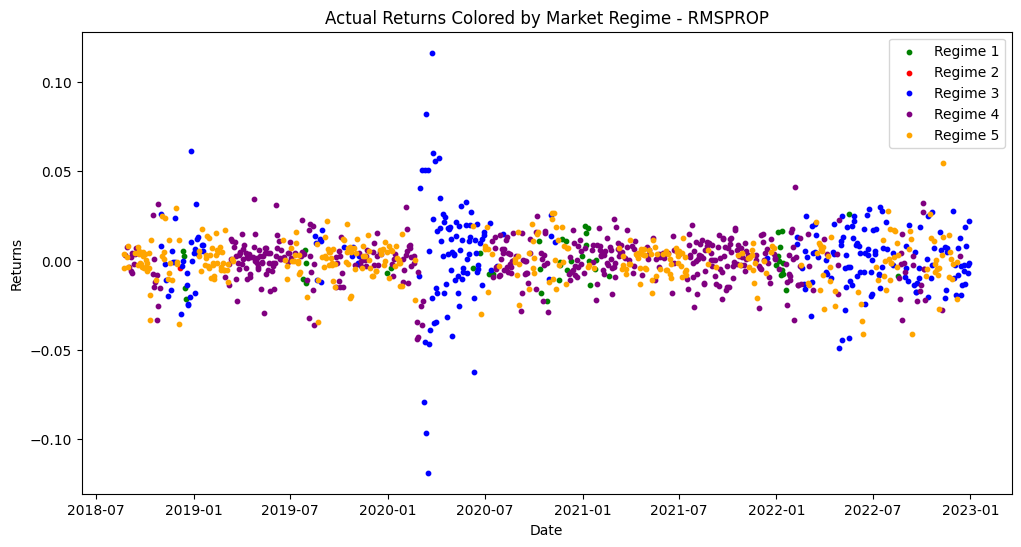

In [ ]:
pi_pred = pi_params[best_opt]
index = portfolio_returns.index[-len(pi_pred) :]
pi_df = pd.DataFrame(pi_pred, index=index)

# Determine dominant component each day
dominant_component = pi_df.idxmax(axis=1)

# Map component indices to market regimes
regime_map = {0: "Regime 1", 1: "Regime 2", 2: "Regime 3", 3: "Regime 4", 4: "Regime 5"}
regimes = dominant_component.map(regime_map)

# Create a DataFrame with regimes
regime_df = pd.DataFrame({"Regime": regimes}, index=pi_df.index)

# Combine actual portfolio_returns with regimes
actual_returns_series = results_opt[best_opt]["Actual_Returns"]
returns_regime = pd.DataFrame({"Returns": actual_returns_series}, index=pi_df.index)
returns_regime = returns_regime.join(regime_df)

# Map regimes to colors
regime_colors = {
    "Regime 1": "green",
    "Regime 2": "red",
    "Regime 3": "blue",
    "Regime 4": "purple",
    "Regime 5": "orange",
}

plt.figure(figsize=(12, 6))
for regime in regime_colors.keys():
    mask = returns_regime["Regime"] == regime
    plt.scatter(
        returns_regime.index[mask],
        returns_regime["Returns"][mask],
        color=regime_colors[regime],
        label=f"{regime}",
        s=10,
    )
plt.title(f"Actual Returns Colored by Market Regime - {best_opt.upper()}")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()